## The Problem: Predicting Restaurant Revenue 



---



---





---
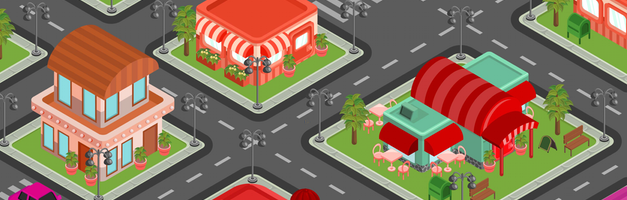


---


##### With over 1,200 quick service restaurants across the globe, TFI is the company behind some of the world's most well-known brands: Burger King, Sbarro, Popeyes, Usta Donerci, and Arby’s. They employ over 20,000 people in Europe and Asia and make significant daily investments in developing new restaurant sites.

##### Right now, deciding when and where to open new restaurants is largely a subjective process based on the personal judgement and experience of development teams. This subjective data is difficult to accurately extrapolate across geographies and cultures. 

##### New restaurant sites take large investments of time and capital to get up and running. When the wrong location for a restaurant brand is chosen, the site closes within 18 months and operating losses are incurred. 

##### Finding a mathematical model to increase the effectiveness of investments in new restaurant sites would allow TFI to invest more in other important business areas, like sustainability, innovation, and training for new employees. Using demographic, real estate, and commercial data, this competition challenges you to predict the annual restaurant sales of 100,000 regional locations.

##### TFI would love to hire an expert Kaggler like you to head up their growing data science team in Istanbul or Shanghai. You'd be tackling problems like the one featured in this competition on a global scale. 

## Data Description

##### TFI has provided a dataset with 137 restaurants in the training set, and a test set of 100000 restaurants. The data columns include the open date, location, city type, and three categories of obfuscated data: Demographic data, Real estate data, and Commercial data. The revenue column indicates a (transformed) revenue of the restaurant in a given year and is the target of predictive analysis. 

Data Field Description

*Column* | Description
:---|:---
`Id` | Restaurant id. 
`Open Date` | opening date for a restaurant
City | City that the restaurant is in. Note that there are unicode in the names. 
City Group| Type of the city. Big cities, or Other. 
Type| Type of the restaurant. FC| Food Court, IL| Inline, DT| Drive Thru, MB| Mobile
P1, P2 - P37| There are three categories of these obfuscated data. Demographic data are gathered from third party providers with GIS systems. These include population in any given area, age and gender distribution, development scales. 
Revenue| The revenue column indicates a (transformed) revenue of the restaurant in a given year and is the target of predictive analysis. Please note that the values are transformed so they don't mean real dollar values. 

### Installing/Importing the necessary Libraries


In [1]:
!pip install vecstack

from vecstack import stacking
import pandas as pd
import numpy as np


from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

import numpy as np
import sklearn
from scipy import stats
import matplotlib.pyplot as plt
import os
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")


%matplotlib inline
import os

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from scipy import stats
from scipy.stats import norm, skew
from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

from google.colab import drive
drive.mount('/gdrive')
#Change current working directory to gdrive
%cd /gdrive

Mounted at /gdrive
/gdrive


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### The distribution of data is quite different as there are more records in the test set than the training set, therefore, what we are seeking to do is to model the revenue basing it on the 137 samples that is given in the training set. 

### Because of the small size of the dataset, using a complicated regression model will certainly result in  overfitting. 

### What can we do to prevent overfitting ? 

### We could implement certain regularization tecniques.

In [3]:
trainfile = r'/content/drive/MyDrive/CIS508/Team_Assignment/Team_Assignment 1_Restaurant_Revenue/train.csv'
trainData = pd.read_csv(trainfile) #creates a dataframe
testfile = r'/content/drive/MyDrive/CIS508/Team_Assignment/Team_Assignment 1_Restaurant_Revenue/test.csv'
testData = pd.read_csv(testfile)  #creates a dataframe


print(trainData.shape)
print(testData.shape)



(137, 43)
(100000, 42)


## The initial stages will always be trying to understand the dataset

### There seems to be no Null or Missing Values here

In [4]:
print(trainData.isnull().sum())

Id            0
Open Date     0
City          0
City Group    0
Type          0
P1            0
P2            0
P3            0
P4            0
P5            0
P6            0
P7            0
P8            0
P9            0
P10           0
P11           0
P12           0
P13           0
P14           0
P15           0
P16           0
P17           0
P18           0
P19           0
P20           0
P21           0
P22           0
P23           0
P24           0
P25           0
P26           0
P27           0
P28           0
P29           0
P30           0
P31           0
P32           0
P33           0
P34           0
P35           0
P36           0
P37           0
revenue       0
dtype: int64


In [5]:
trainData.head()

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,0,07/17/1999,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,...,3.0,5,3,4,5,5,4,3,4,5653753.0
1,1,02/14/2008,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,...,3.0,0,0,0,0,0,0,0,0,6923131.0
2,2,03/09/2013,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,...,3.0,0,0,0,0,0,0,0,0,2055379.0
3,3,02/02/2012,Tokat,Other,IL,6,4.5,6.0,6.0,4,...,7.5,25,12,10,6,18,12,12,6,2675511.0
4,4,05/09/2009,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,...,3.0,5,1,3,2,3,4,3,3,4316715.0


In [6]:
pd.set_option('display.max_columns', None)
testData.head()

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37
0,0,01/22/2011,Niğde,Other,FC,1,4.0,4.0,4.0,1,2,5,4,5,5,5,3,4.0,0,0,0,2,0,5,5,3,1,4,0,0,0.0,0.0,2.0,3.0,0,0,0,0,0,0,0,0
1,1,03/18/2011,Konya,Other,IL,3,4.0,4.0,4.0,2,2,5,3,4,4,2,4,5.0,0,0,0,0,0,5,5,3,2,1,0,0,0.0,0.0,1.0,3.0,0,0,0,0,0,0,0,0
2,2,10/30/2013,Ankara,Big Cities,FC,3,4.0,4.0,4.0,2,2,5,4,4,5,4,5,5.0,0,0,0,0,0,5,5,5,5,5,0,0,0.0,0.0,2.0,3.0,0,0,0,0,0,0,0,0
3,3,05/06/2013,Kocaeli,Other,IL,2,4.0,4.0,4.0,2,3,5,4,5,4,3,4,5.0,0,0,0,0,4,4,4,3,2,2,0,0,0.0,0.0,2.0,3.0,0,4,0,0,0,0,0,0
4,4,07/31/2013,Afyonkarahisar,Other,FC,2,4.0,4.0,4.0,1,2,5,4,5,4,3,5,4.0,0,0,0,0,0,1,5,3,1,1,0,0,0.0,0.0,5.0,3.0,0,0,0,0,0,0,0,0


## Exploratory Data Analysis

#### It seems Istanbul has the highest count in terms of cities and the Data seems to be of Turkey 

In [7]:
counts = testData['City'].value_counts() #counts unique values
percent = ((testData['City'].value_counts()/testData['City'].value_counts().sum())*100).round(1).astype(str) + '%'
pd.DataFrame({'count':counts,'percentage':percent}).head(5)

,count,percentage
İstanbul,34087,34.1%
Ankara,8720,8.7%
İzmir,6465,6.5%
Antalya,5911,5.9%
Kocaeli,4364,4.4%


In [8]:
pd.to_datetime(trainData['Open Date'], errors='raise', dayfirst=False, yearfirst=True, utc=None, format=None, exact=True, unit=None, infer_datetime_format=False, origin='unix', cache=True)
pd.to_datetime(testData['Open Date'], errors='raise', dayfirst=False, yearfirst=True, utc=None, format=None, exact=True, unit=None, infer_datetime_format=False, origin='unix', cache=True)


0       2011-01-22
1       2011-03-18
2       2013-10-30
3       2013-05-06
4       2013-07-31
           ...    
99995   2000-01-05
99996   2011-07-18
99997   2012-12-29
99998   2013-10-12
99999   2010-10-05
Name: Open Date, Length: 100000, dtype: datetime64[ns]

#### Next what we can do is split the Opening Date of the restaurants into more relevant columns or features such as how old the restaurant is as of the current date that is 30-03-2022 for this dataset.

In [9]:
#generating new features from 'Open Date' feature
def newFeatures(df):
  df['Date'] = pd.to_datetime(df['Open Date'],format="%m/%d/%Y")
  df['Year Open'] = df['Date'].dt.year
  df['Month'] = df['Date'].dt.month
  df['Years Old'] = pd.to_datetime('30-03-2022').year - df['Date'].dt.year
  df = df.drop(['Open Date','Date'],axis=1)
  return df

train = newFeatures(trainData)
test = newFeatures(testData)

In [10]:
train.head()

,Id,City,City Group,Type,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue,Year Open,Month,Years Old
0,0,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,2,5,4,5,5,3,5,5.0,1,2,2,2,4,5,4,1,3,3,1,1,1.0,4.0,2.0,3.0,5,3,4,5,5,4,3,4,5653753.0,1999,7,23
1,1,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,2,5,5,5,5,1,5,5.0,0,0,0,0,0,3,2,1,3,2,0,0,0.0,0.0,3.0,3.0,0,0,0,0,0,0,0,0,6923131.0,2008,2,14
2,2,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,3,5,5,5,5,2,5,5.0,0,0,0,0,0,1,1,1,1,1,0,0,0.0,0.0,1.0,3.0,0,0,0,0,0,0,0,0,2055379.0,2013,3,9
3,3,Tokat,Other,IL,6,4.5,6.0,6.0,4,4,10,8,10,10,8,10,7.5,6,4,9,3,12,20,12,6,1,10,2,2,2.5,2.5,2.5,7.5,25,12,10,6,18,12,12,6,2675511.0,2012,2,10
4,4,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,2,5,5,5,5,2,5,5.0,2,1,2,1,4,2,2,1,2,1,2,3,3.0,5.0,1.0,3.0,5,1,3,2,3,4,3,3,4316715.0,2009,5,13


In [11]:
test.head()

,Id,City,City Group,Type,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37,Year Open,Month,Years Old
0,0,Niğde,Other,FC,1,4.0,4.0,4.0,1,2,5,4,5,5,5,3,4.0,0,0,0,2,0,5,5,3,1,4,0,0,0.0,0.0,2.0,3.0,0,0,0,0,0,0,0,0,2011,1,11
1,1,Konya,Other,IL,3,4.0,4.0,4.0,2,2,5,3,4,4,2,4,5.0,0,0,0,0,0,5,5,3,2,1,0,0,0.0,0.0,1.0,3.0,0,0,0,0,0,0,0,0,2011,3,11
2,2,Ankara,Big Cities,FC,3,4.0,4.0,4.0,2,2,5,4,4,5,4,5,5.0,0,0,0,0,0,5,5,5,5,5,0,0,0.0,0.0,2.0,3.0,0,0,0,0,0,0,0,0,2013,10,9
3,3,Kocaeli,Other,IL,2,4.0,4.0,4.0,2,3,5,4,5,4,3,4,5.0,0,0,0,0,4,4,4,3,2,2,0,0,0.0,0.0,2.0,3.0,0,4,0,0,0,0,0,0,2013,5,9
4,4,Afyonkarahisar,Other,FC,2,4.0,4.0,4.0,1,2,5,4,5,4,3,5,4.0,0,0,0,0,0,1,5,3,1,1,0,0,0.0,0.0,5.0,3.0,0,0,0,0,0,0,0,0,2013,7,9


#### There seems to be a slight problem with the dataset as train data has 34 cities whereas the test data has about 57 cities. 

The possible solution is that I get the common cities across these two sets and for all other cities not in the intersection of these two sets, i will label them as 'Others'

In [12]:
(train['City'].nunique(), test['City'].nunique())

(34, 57)

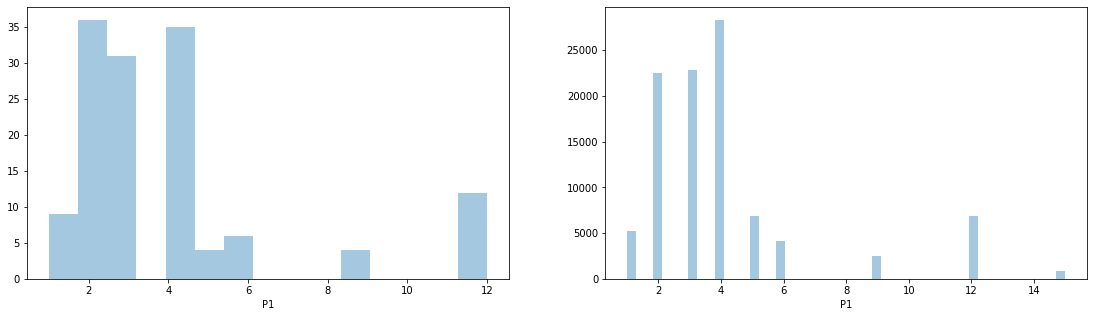

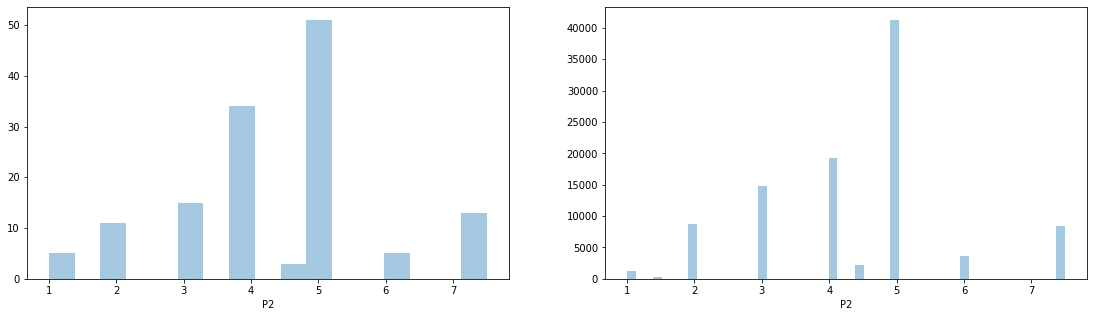

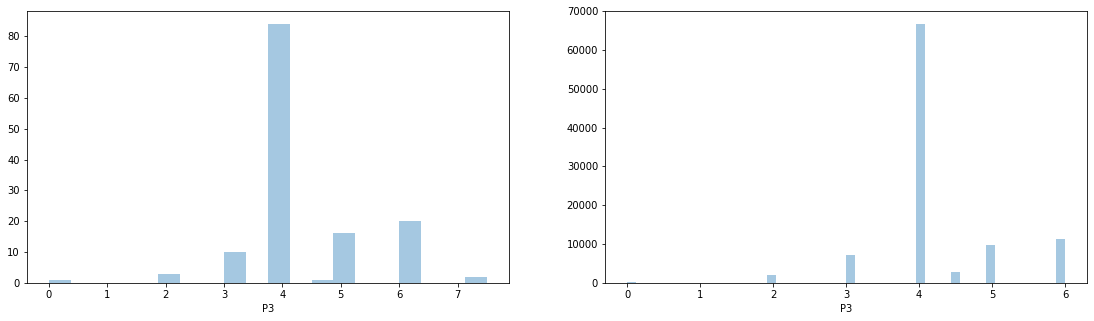

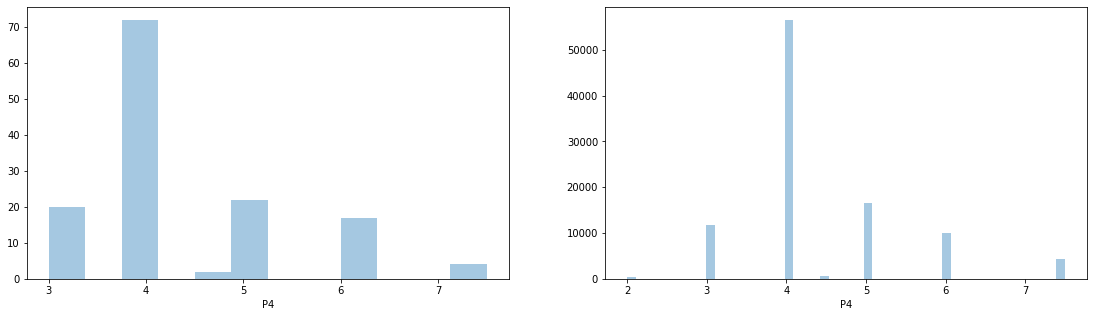

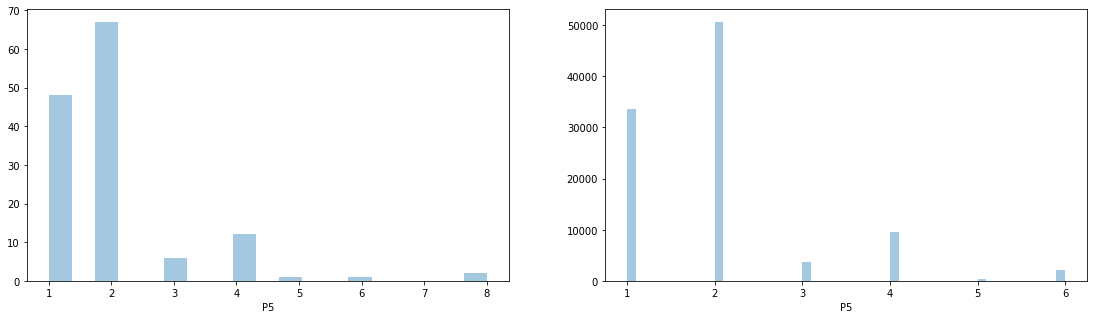

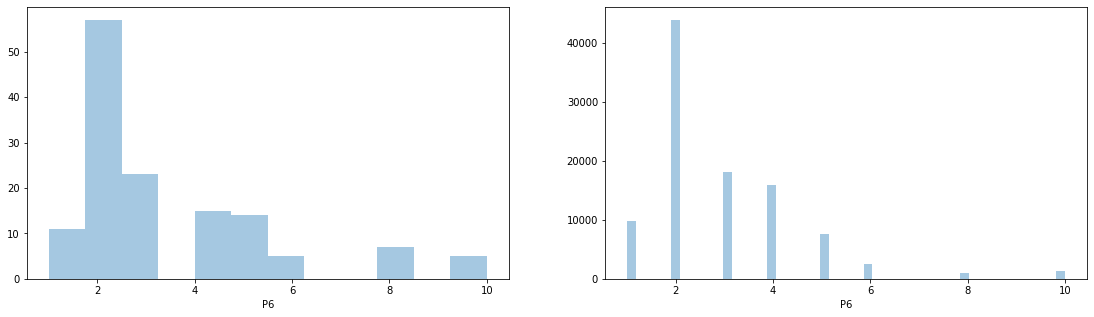

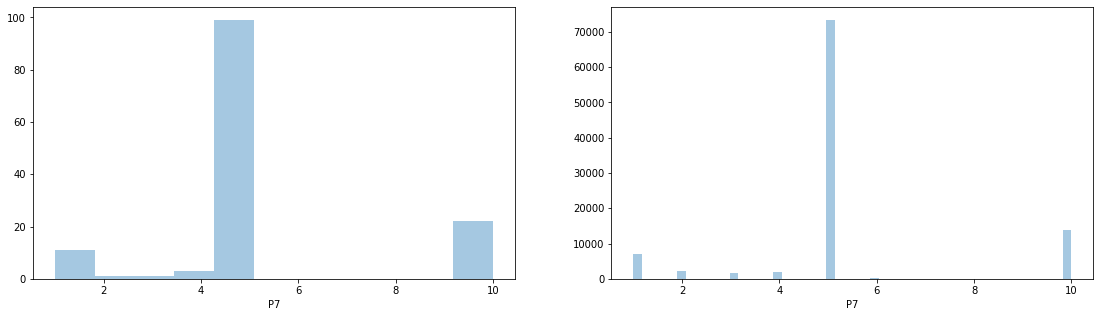

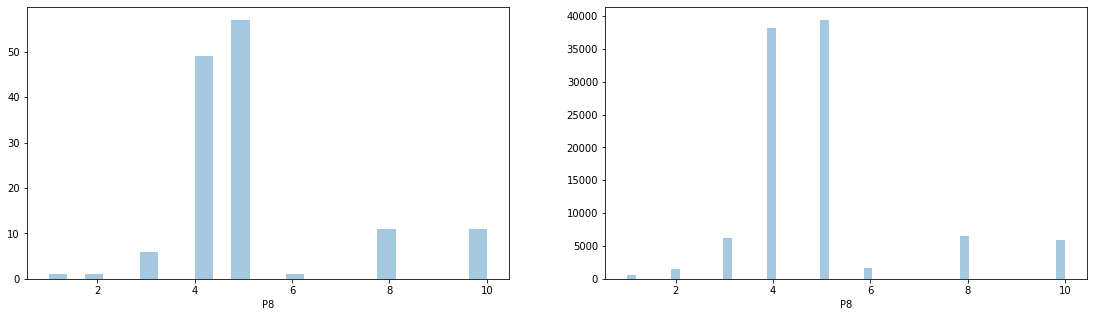

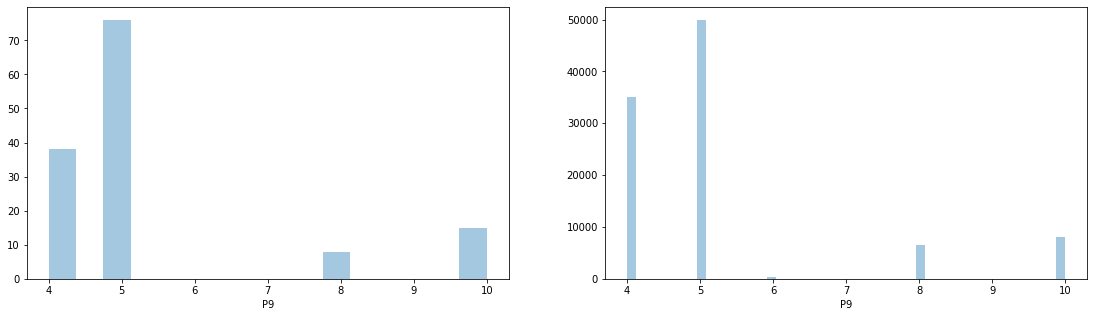

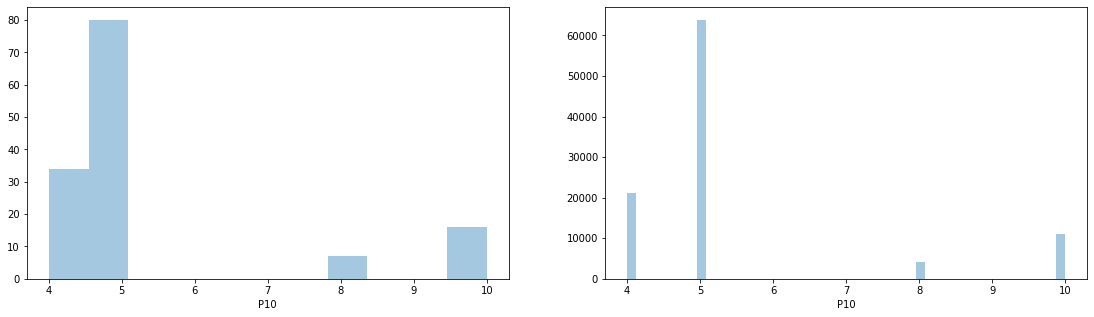

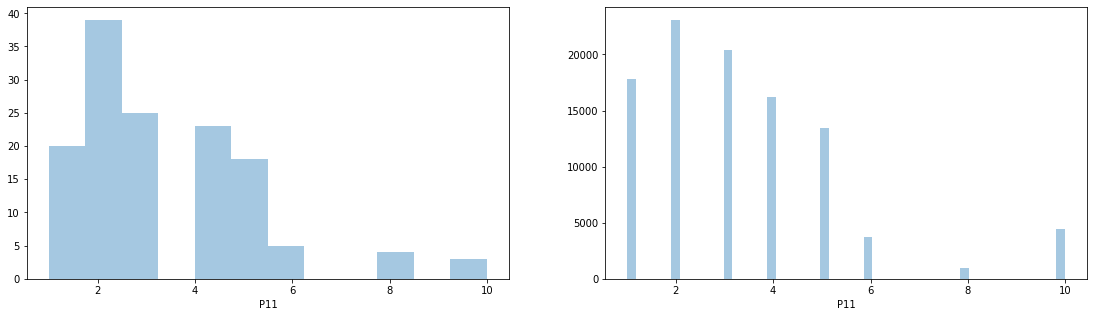

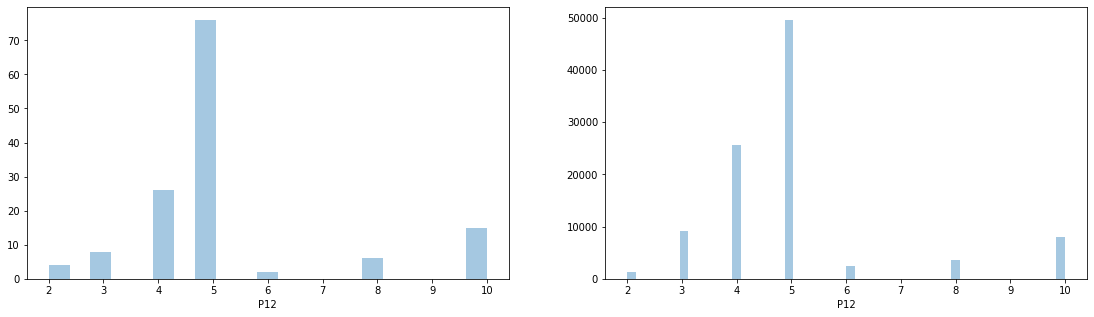

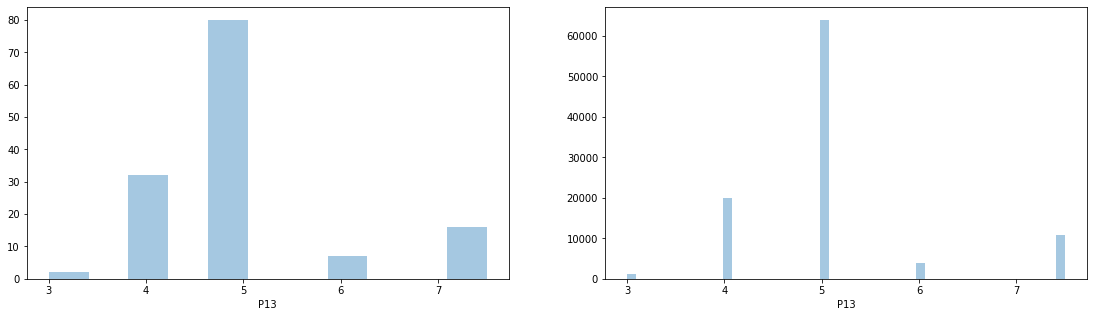

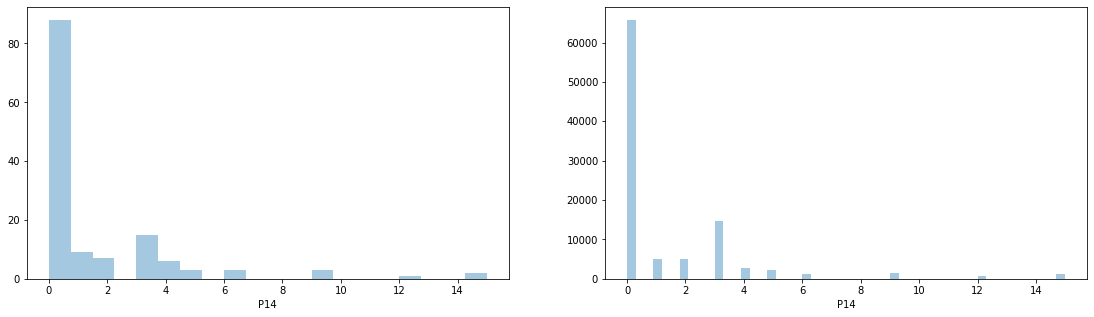

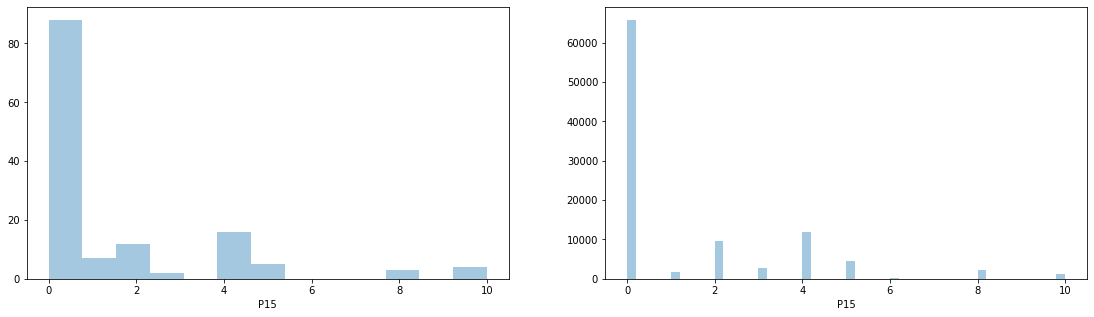

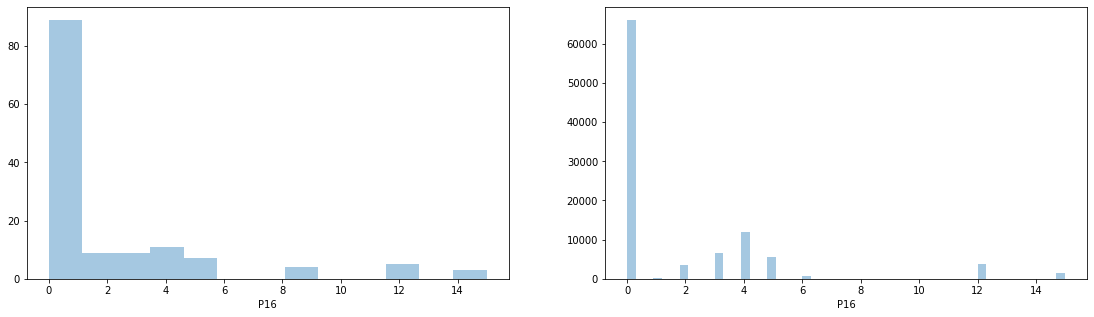

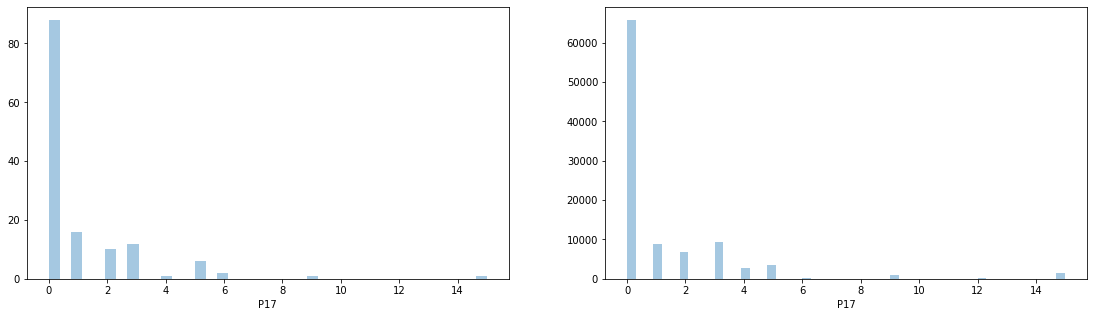

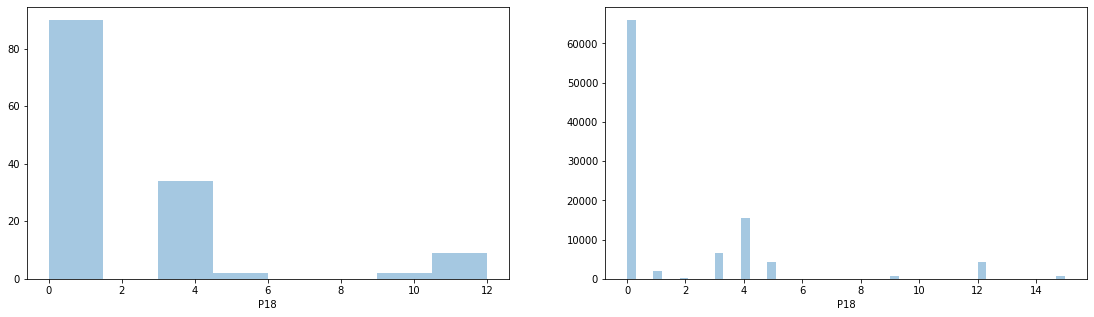

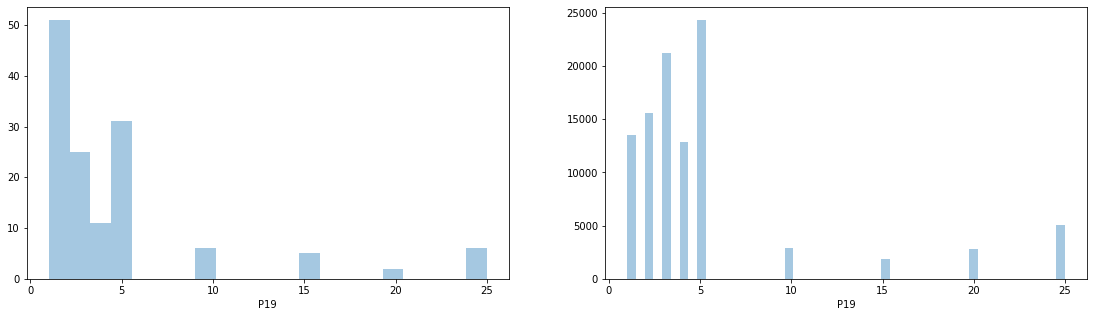

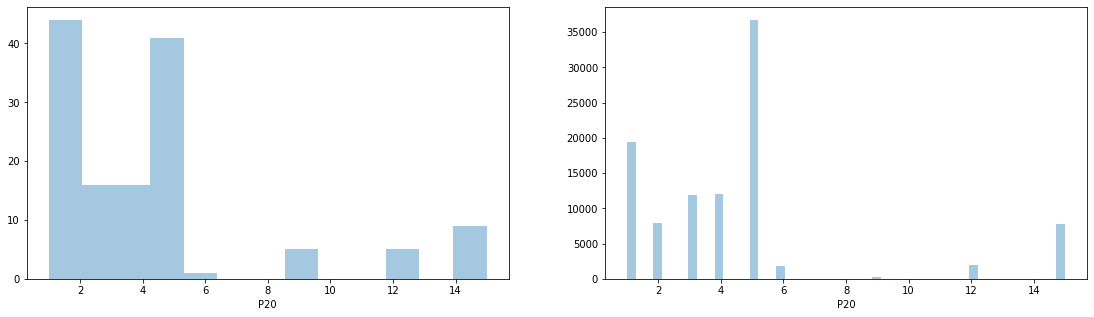

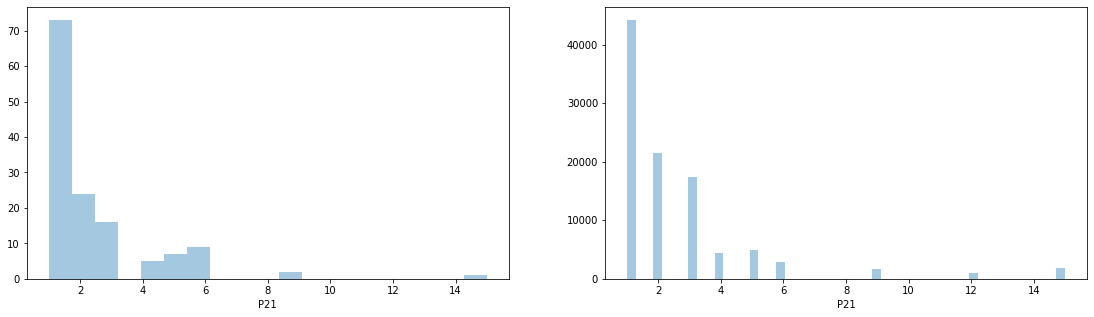

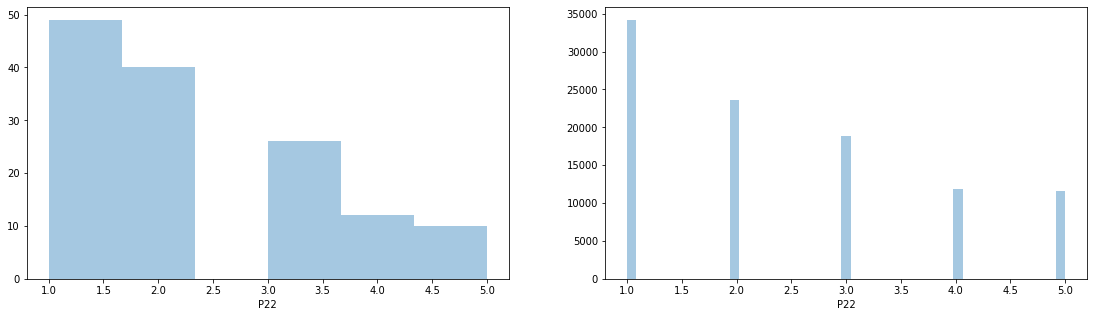

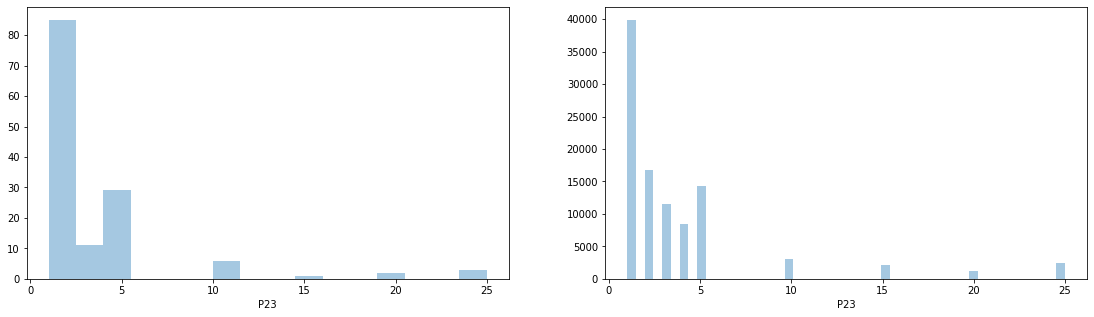

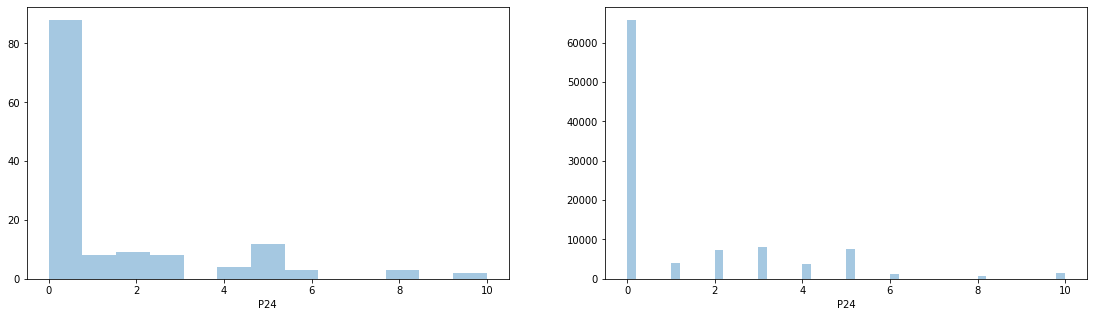

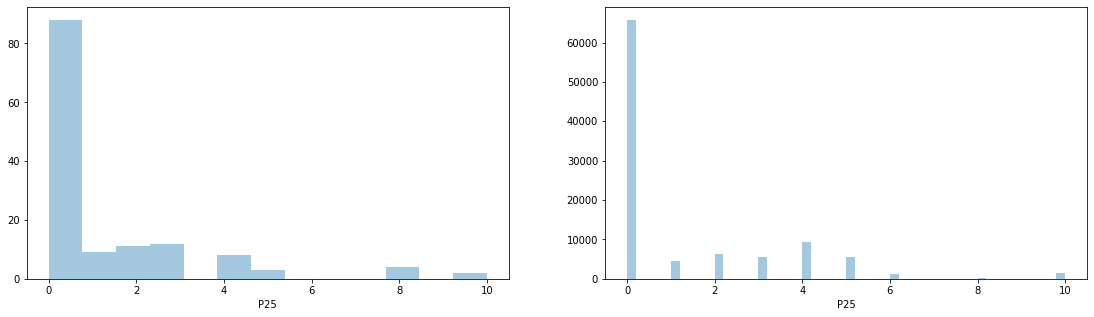

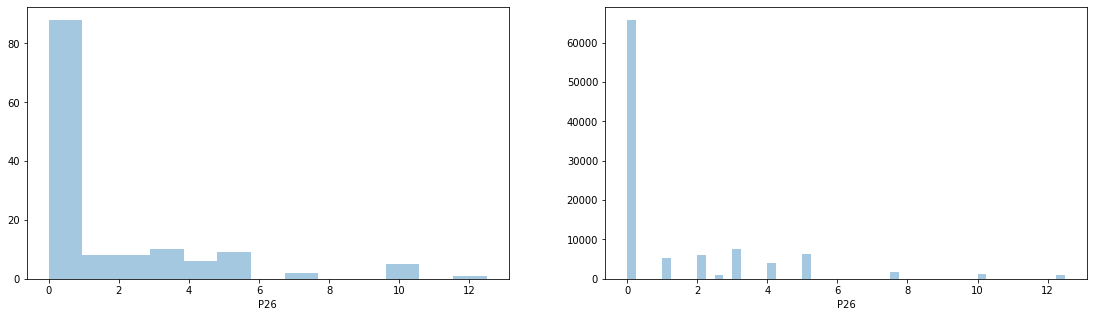

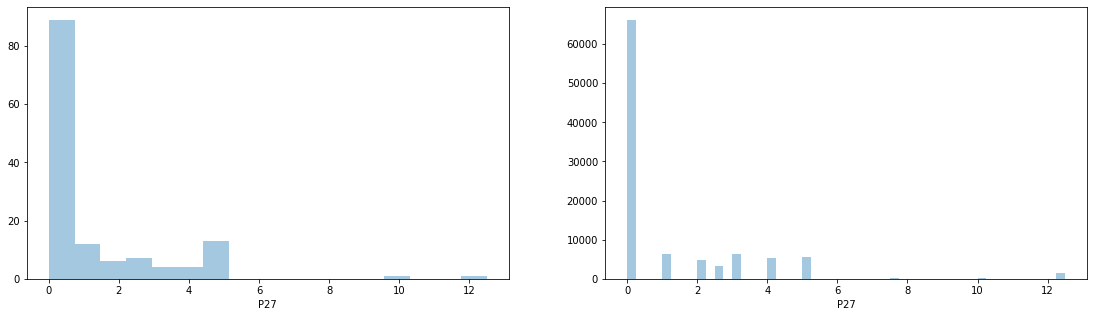

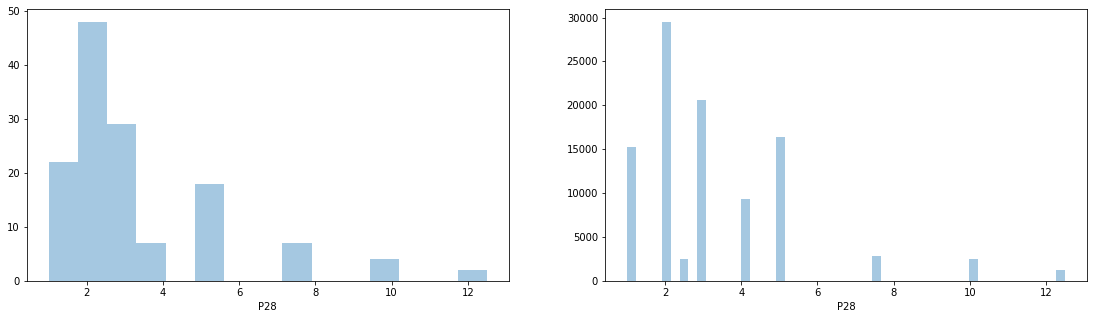

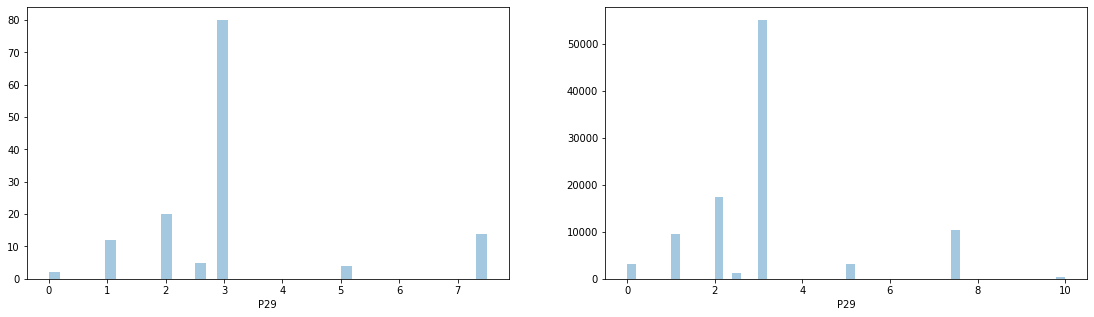

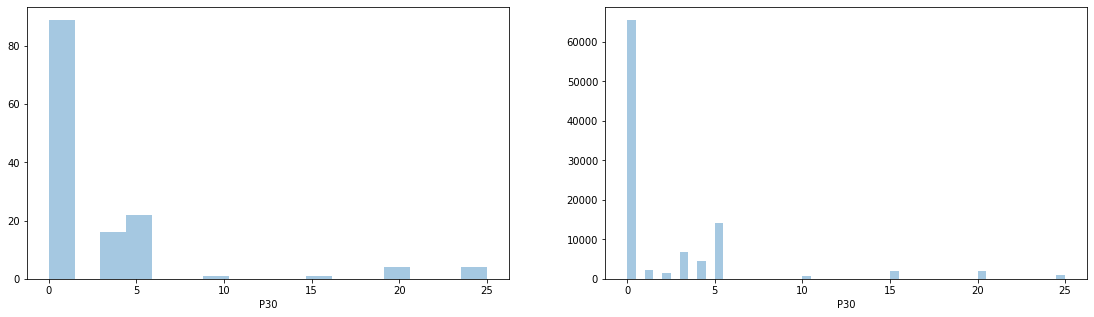

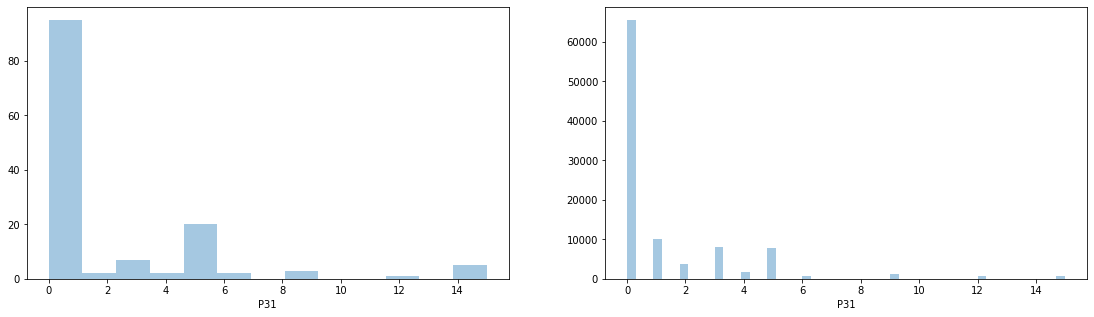

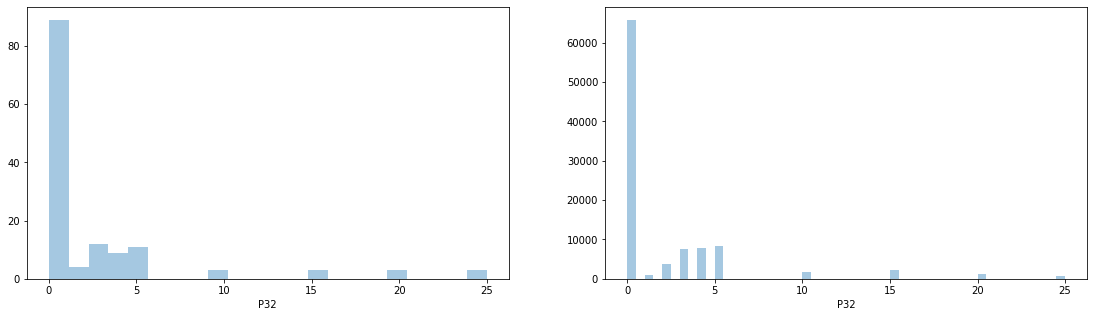

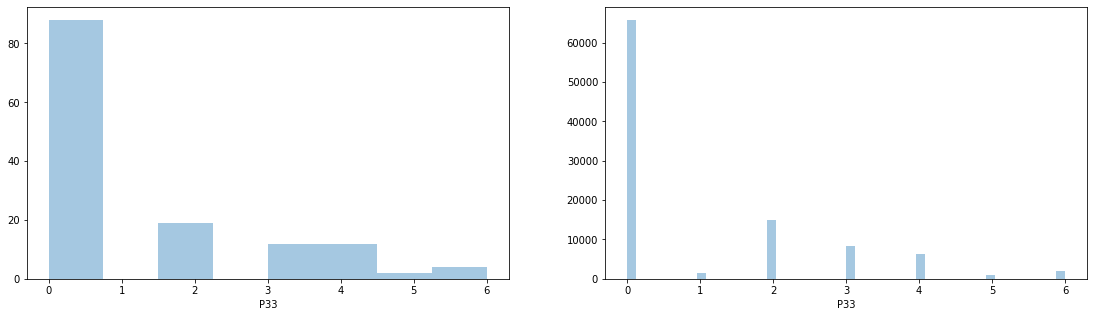

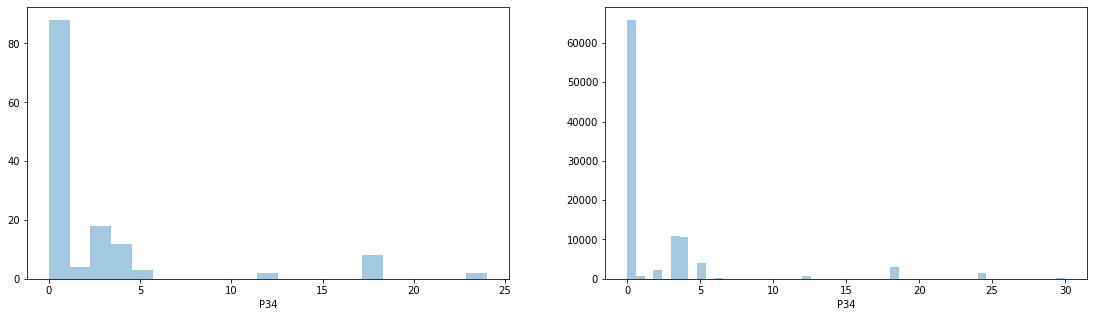

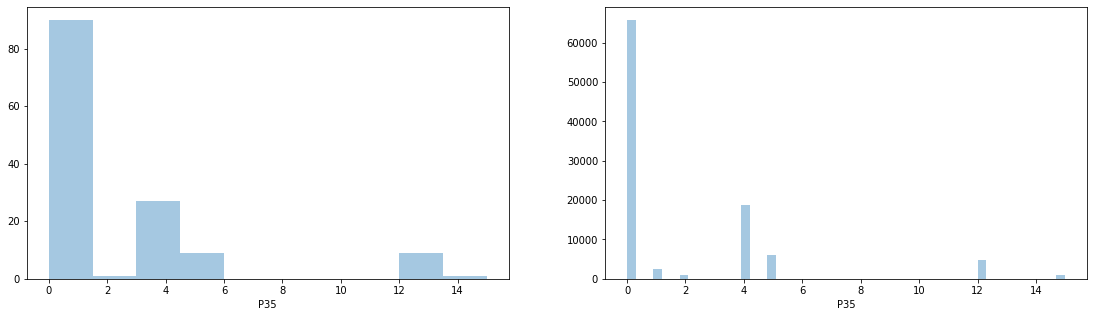

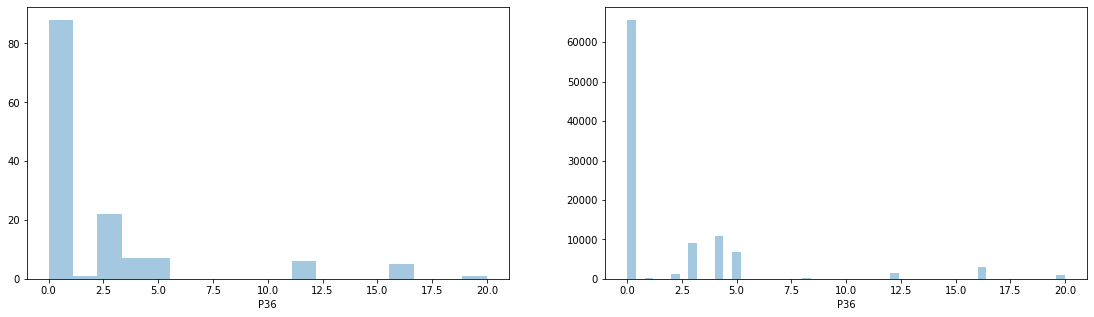

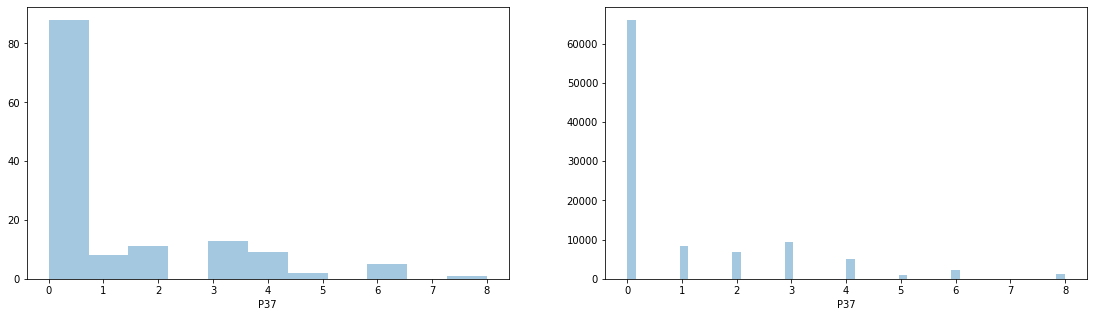

In [13]:
plt.rc('figure', max_open_warning = 0)
for i in range(1,38):
    fig, ax = plt.subplots(1,2, figsize=(19, 5))
    g1 = sns.distplot(train['P{}'.format(i)], ax=ax[0], kde=False);
    g2 = sns.distplot(test['P{}'.format(i)], ax=ax[1], kde=False);
    fig.show()

### In terms of revenue Istanbul is the highest followed by Elazig and others

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]),
 <a list of 34 Text major ticklabel objects>)

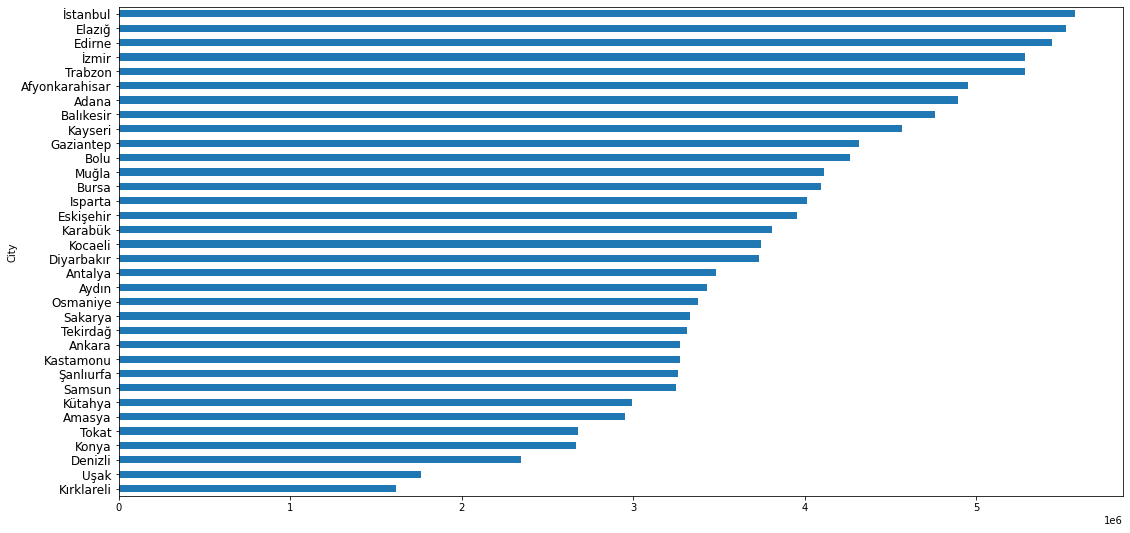

In [14]:
train.groupby(['City']).mean()['revenue'].sort_values().plot.barh(figsize=(18,9))
plt.yticks(fontsize=12)

Taking the common citiies across the train and test datasets

In [15]:
common_city = list(set(trainData.City) & set(testData.City))

In [16]:
common_city

['Bursa',
 'Uşak',
 'Kocaeli',
 'İstanbul',
 'Ankara',
 'Gaziantep',
 'Samsun',
 'Diyarbakır',
 'Edirne',
 'Aydın',
 'Eskişehir',
 'Adana',
 'Denizli',
 'Kayseri',
 'Konya',
 'Kütahya',
 'Afyonkarahisar',
 'Antalya',
 'İzmir',
 'Kırklareli',
 'Şanlıurfa',
 'Trabzon',
 'Bolu',
 'Balıkesir',
 'Isparta',
 'Muğla',
 'Tekirdağ',
 'Sakarya']

Labelling all other cities as 'Other'

In [17]:
train.loc[~train.City.isin(common_city), 'City'] = 'Other'

In [18]:
test.loc[~test.City.isin(common_city), 'City'] = 'Other'

In [19]:
train[train['City'] =='Other']

,Id,City,City Group,Type,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue,Year Open,Month,Years Old
3,3,Other,Other,IL,6,4.5,6.0,6.0,4,4,10,8,10,10,8,10,7.5,6,4,9,3,12,20,12,6,1,10,2,2,2.5,2.5,2.5,7.5,25,12,10,6,18,12,12,6,2675511.0,2012,2,10
20,20,Other,Other,IL,3,4.0,4.0,4.0,2,2,5,4,5,5,3,5,5.0,3,5,5,4,4,5,5,1,1,5,2,4,1.0,5.0,1.0,3.0,5,1,2,2,4,5,5,4,5525735.0,2010,8,12
51,51,Other,Other,IL,2,2.0,4.0,4.0,2,2,4,4,5,5,4,5,5.0,0,0,0,0,0,5,4,2,1,2,0,0,0.0,0.0,1.0,3.0,0,0,0,0,0,0,0,0,3273041.0,2011,11,11
82,82,Other,Other,FC,2,2.0,4.0,3.0,2,1,5,4,5,5,5,5,5.0,0,0,0,0,0,5,4,2,2,2,0,0,0.0,0.0,2.0,3.0,0,0,0,0,0,0,0,0,3807496.0,2010,2,12
110,110,Other,Other,IL,6,3.0,6.0,6.0,4,4,10,8,10,10,6,10,7.5,9,8,12,3,12,10,12,6,1,10,2,2,2.5,2.5,5.0,7.5,15,3,15,6,18,12,16,6,2954086.0,2012,9,10
130,130,Other,Other,FC,3,4.0,3.0,4.0,2,1,5,5,5,5,2,5,5.0,0,0,0,0,0,3,1,1,1,1,0,0,0.0,0.0,2.0,3.0,0,0,0,0,0,0,0,0,3376145.0,2011,10,11


In [20]:
test.head()

,Id,City,City Group,Type,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37,Year Open,Month,Years Old
0,0,Other,Other,FC,1,4.0,4.0,4.0,1,2,5,4,5,5,5,3,4.0,0,0,0,2,0,5,5,3,1,4,0,0,0.0,0.0,2.0,3.0,0,0,0,0,0,0,0,0,2011,1,11
1,1,Konya,Other,IL,3,4.0,4.0,4.0,2,2,5,3,4,4,2,4,5.0,0,0,0,0,0,5,5,3,2,1,0,0,0.0,0.0,1.0,3.0,0,0,0,0,0,0,0,0,2011,3,11
2,2,Ankara,Big Cities,FC,3,4.0,4.0,4.0,2,2,5,4,4,5,4,5,5.0,0,0,0,0,0,5,5,5,5,5,0,0,0.0,0.0,2.0,3.0,0,0,0,0,0,0,0,0,2013,10,9
3,3,Kocaeli,Other,IL,2,4.0,4.0,4.0,2,3,5,4,5,4,3,4,5.0,0,0,0,0,4,4,4,3,2,2,0,0,0.0,0.0,2.0,3.0,0,4,0,0,0,0,0,0,2013,5,9
4,4,Afyonkarahisar,Other,FC,2,4.0,4.0,4.0,1,2,5,4,5,4,3,5,4.0,0,0,0,0,0,1,5,3,1,1,0,0,0.0,0.0,5.0,3.0,0,0,0,0,0,0,0,0,2013,7,9


In [21]:
train.head()

,Id,City,City Group,Type,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue,Year Open,Month,Years Old
0,0,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,2,5,4,5,5,3,5,5.0,1,2,2,2,4,5,4,1,3,3,1,1,1.0,4.0,2.0,3.0,5,3,4,5,5,4,3,4,5653753.0,1999,7,23
1,1,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,2,5,5,5,5,1,5,5.0,0,0,0,0,0,3,2,1,3,2,0,0,0.0,0.0,3.0,3.0,0,0,0,0,0,0,0,0,6923131.0,2008,2,14
2,2,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,3,5,5,5,5,2,5,5.0,0,0,0,0,0,1,1,1,1,1,0,0,0.0,0.0,1.0,3.0,0,0,0,0,0,0,0,0,2055379.0,2013,3,9
3,3,Other,Other,IL,6,4.5,6.0,6.0,4,4,10,8,10,10,8,10,7.5,6,4,9,3,12,20,12,6,1,10,2,2,2.5,2.5,2.5,7.5,25,12,10,6,18,12,12,6,2675511.0,2012,2,10
4,4,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,2,5,5,5,5,2,5,5.0,2,1,2,1,4,2,2,1,2,1,2,3,3.0,5.0,1.0,3.0,5,1,3,2,3,4,3,3,4316715.0,2009,5,13


Now we can see the unique values for City feature is balanced across train and test set

In [22]:
(train['City'].nunique(), test['City'].nunique())

(29, 29)

## Creating a Pivot Table to get a chart to compare the revenue by city by year open

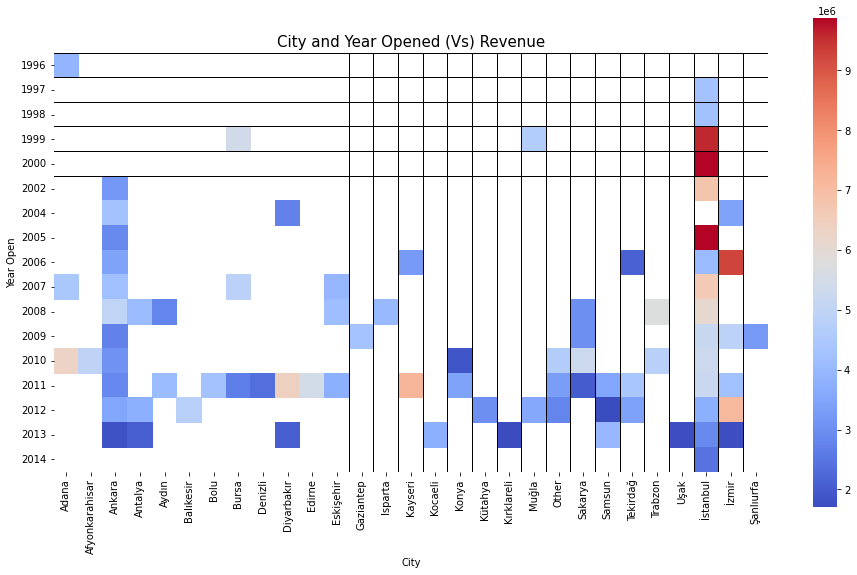

In [23]:
df = pd.DataFrame({'City':train['City'],'Year Open':train['Year Open'],'revenue':train['revenue']})

df_wide=df.pivot_table( index='Year Open', columns='City', values='revenue' )

fig, ax = plt.subplots(figsize=(16,9))         #linecolors can be 'r', 'g', 'b', 'k', 'y', 'm', 'c'
plot = sns.heatmap(df_wide, annot=False,linewidths=.001,linecolor='k',ax=ax,cmap='coolwarm',robust=True, square=True) #annot=True writes data in rect boxes
plt.title('City and Year Opened (Vs) Revenue',size=15)
plt.show()

### In comparing the Type column across train and test data it seems our test data has a unique value 'MB' which we can drop or replace with DT, for this analysis we will replace this with DT

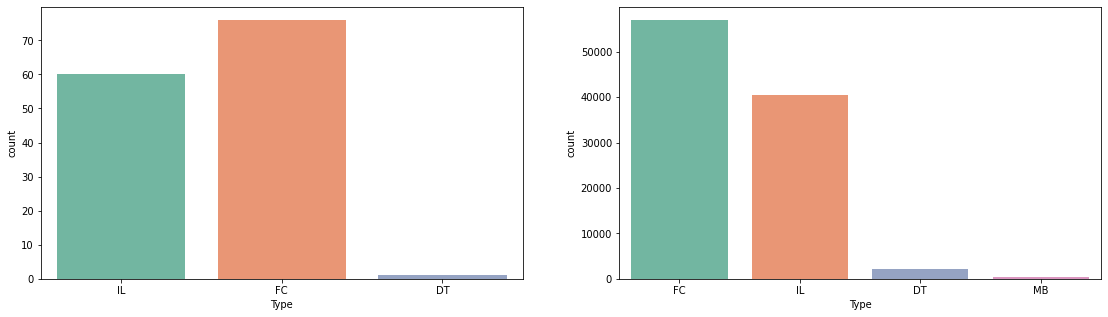

In [24]:
fig, ax = plt.subplots(1,2, figsize=(19, 5))
g1 = sns.countplot(train['Type'],palette="Set2", ax=ax[0]);
g2 = sns.countplot(test['Type'],palette="Set2", ax=ax[1]);
fig.show()

In [25]:
test.loc[test['Type']=='MB', 'Type'] = 'DT'

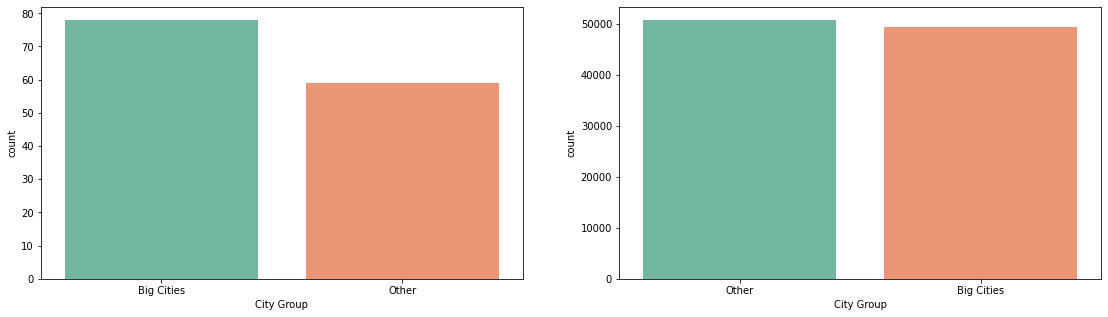

In [26]:
fig, ax = plt.subplots(1,2, figsize=(19, 5))
g1 = sns.countplot(train['City Group'],palette="Set2", ax=ax[0]);
g2 = sns.countplot(test['City Group'],palette="Set2", ax=ax[1]);
fig.show()

In [27]:
train['City Group'].value_counts()


Big Cities    78
Other         59
Name: City Group, dtype: int64

## Understanding the Target Variable Distribution

#### It seems like there are some outliers in the data as well as the data being  skewed to the right. One option is to log transform it now and then use an exponent transformation to rescale it for submission to get the Kaggle Scores

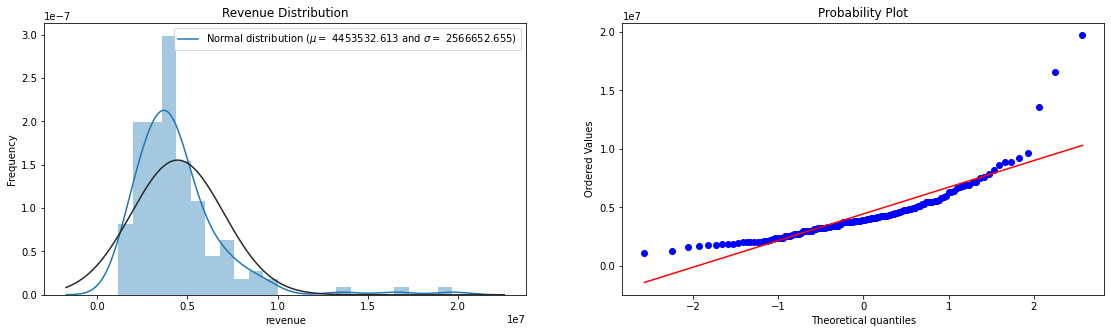

In [28]:
from scipy import stats
from scipy.stats import norm, skew
(mu, sigma) = norm.fit(train['revenue'])
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(19, 5))
ax1 = sns.distplot(train['revenue'] , fit=norm, ax=ax1)
ax1.legend([f'Normal distribution ($\mu=$ {mu:.3f} and $\sigma=$ {sigma:.3f})'], loc='best')
ax1.set_ylabel('Frequency')
ax1.set_title('Revenue Distribution')
ax2 = stats.probplot(train['revenue'], plot=plt)
f.show();

### There seems to be some outliers in the Big Cities Group as shown by the Box Plot below

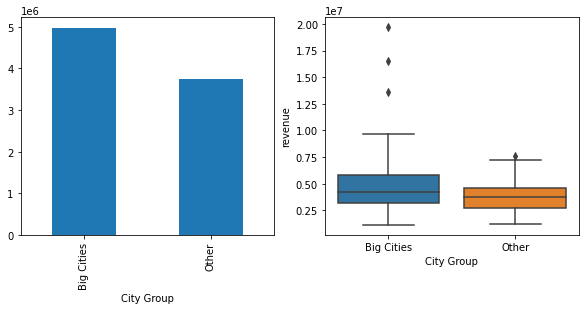

In [29]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
train.groupby(['City Group']).mean()['revenue'].plot.bar(ax=ax1)
sns.boxplot(x='City Group',y='revenue', data=train,ax=ax2)

In [30]:
train.head()

,Id,City,City Group,Type,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue,Year Open,Month,Years Old
0,0,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,2,5,4,5,5,3,5,5.0,1,2,2,2,4,5,4,1,3,3,1,1,1.0,4.0,2.0,3.0,5,3,4,5,5,4,3,4,5653753.0,1999,7,23
1,1,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,2,5,5,5,5,1,5,5.0,0,0,0,0,0,3,2,1,3,2,0,0,0.0,0.0,3.0,3.0,0,0,0,0,0,0,0,0,6923131.0,2008,2,14
2,2,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,3,5,5,5,5,2,5,5.0,0,0,0,0,0,1,1,1,1,1,0,0,0.0,0.0,1.0,3.0,0,0,0,0,0,0,0,0,2055379.0,2013,3,9
3,3,Other,Other,IL,6,4.5,6.0,6.0,4,4,10,8,10,10,8,10,7.5,6,4,9,3,12,20,12,6,1,10,2,2,2.5,2.5,2.5,7.5,25,12,10,6,18,12,12,6,2675511.0,2012,2,10
4,4,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,2,5,5,5,5,2,5,5.0,2,1,2,1,4,2,2,1,2,1,2,3,3.0,5.0,1.0,3.0,5,1,3,2,3,4,3,3,4316715.0,2009,5,13


# CORRELATION STUDY

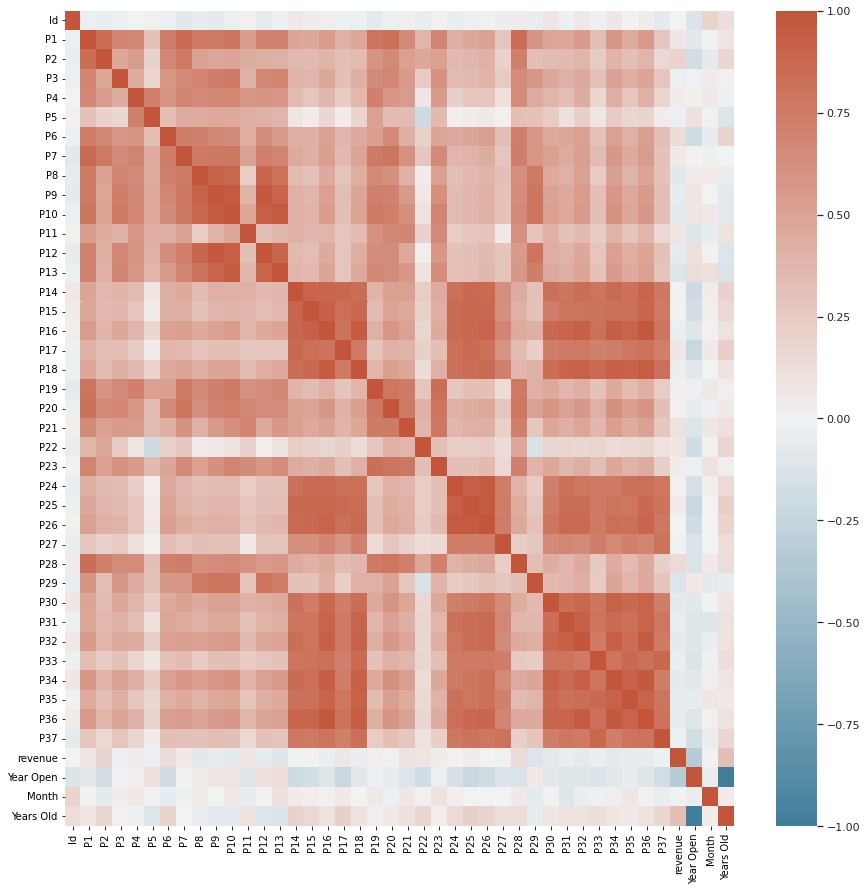

In [31]:
f,ax=plt.subplots(figsize=(15,15))

cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.set_theme(style="white")
sns.heatmap(train.corr(),annot=False,cmap=cmap)

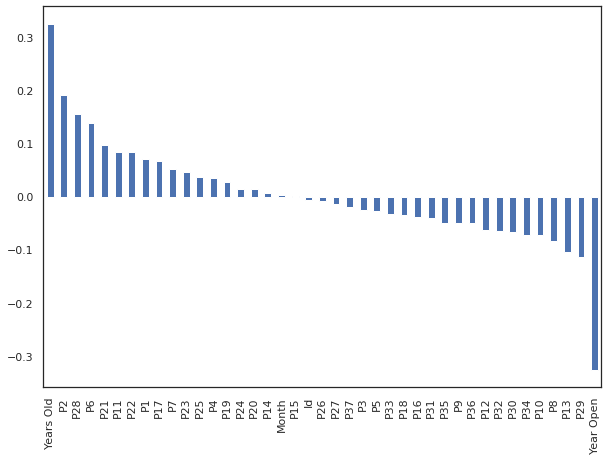

In [32]:

corr_with_revenue = train.drop(['City','City Group','Type'],axis=1).corr()['revenue'].sort_values(ascending=False)
plt.figure(figsize=(10,7))
corr_with_revenue.drop('revenue').plot.bar()
plt.show();

In [33]:
# trainData['Open Date'] = pd.to_datetime(trainData['Open Date'], errors='raise', dayfirst=False, yearfirst=True, utc=None, format=None, exact=True, unit=None, infer_datetime_format=False, origin='unix', cache=True)
# testData['Open Date'] = pd.to_datetime(testData['Open Date'], errors='raise', dayfirst=False, yearfirst=True, utc=None, format=None, exact=True, unit=None, infer_datetime_format=False, origin='unix', cache=True)


In [34]:
# trainData['open_year'] = trainData['Open Date'].dt.year
# # Do it to the test data 
# testData['open_year'] = testData['Open Date'].dt.year

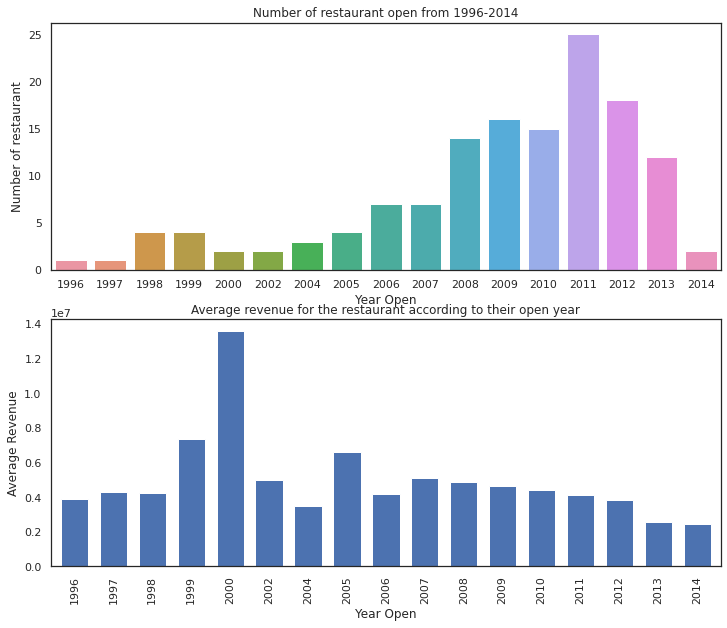

In [35]:
fig = plt.figure(figsize=(12,10))
ax1=fig.add_subplot(2,1,1)
ax2=fig.add_subplot(2,1,2)

sns.countplot(train['Year Open'],ax=ax1)
ax1.set_title('Number of restaurant open from 1996-2014')
ax1.set_ylabel('Number of restaurant')

train.groupby(['Year Open']).mean()['revenue'].plot.bar(ax=ax2, width=0.7)
ax2.set_title('Average revenue for the restaurant according to their open year')
ax2.set_ylabel('Average Revenue')

plt.show()

In [36]:
TrainCols = list(train.columns.values)
TestCols = list(test.columns.values)
print(TrainCols)
print(TestCols)

['Id', 'City', 'City Group', 'Type', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 'P23', 'P24', 'P25', 'P26', 'P27', 'P28', 'P29', 'P30', 'P31', 'P32', 'P33', 'P34', 'P35', 'P36', 'P37', 'revenue', 'Year Open', 'Month', 'Years Old']
['Id', 'City', 'City Group', 'Type', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 'P23', 'P24', 'P25', 'P26', 'P27', 'P28', 'P29', 'P30', 'P31', 'P32', 'P33', 'P34', 'P35', 'P36', 'P37', 'Year Open', 'Month', 'Years Old']


#Imputing Multivariate imputation by chained equations (MICE)

### Although the P-Variables in the dataset might appear numerical, however, if we look at some of the discussions on Kaggle it will appear that there are alot of missing values especially if we quickly observe for P34 and P35. It seems that they are of a categorical nature and the NaN values have been replaced with 0's. Thus imputation of the P variables seem necessary for this dataset. 

### We are going to use the entire dataset to estimate the missing values, this appears to be the best option, although there are many approaches. The Imputer is separately used across all the columns. 



In [37]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp_train = IterativeImputer(max_iter=30, missing_values=0, sample_posterior=True, min_value=1, random_state=37)
imp_test = IterativeImputer(max_iter=30, missing_values=0, sample_posterior=True, min_value=1, random_state=23)

p_data = ['P'+str(i) for i in range(1,38)]
train[p_data] = np.round(imp_train.fit_transform(train[p_data]))
test[p_data] = np.round(imp_test.fit_transform(test[p_data]))

#One Hot Encoding of the Categorical COlumns

#### This is an essential step to deal with 'Object' type data in the dataset, in our case we have columns like City, City Group, Type which can cause problems for modelling if not encoded numerically. One Hot Encoding provides the easiest and best methods for this

In [40]:
#ONE HOT ENCODING 

columnsToEncode = train.select_dtypes(include=[object]).columns
df = pd.get_dummies(train, columns=columnsToEncode, drop_first=False)
df_test = pd.get_dummies(test, columns=columnsToEncode, drop_first=False)



In [41]:
df.head()

,Id,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue,Year Open,Month,Years Old,City_Adana,City_Afyonkarahisar,City_Ankara,City_Antalya,City_Aydın,City_Balıkesir,City_Bolu,City_Bursa,City_Denizli,City_Diyarbakır,City_Edirne,City_Eskişehir,City_Gaziantep,City_Isparta,City_Kayseri,City_Kocaeli,City_Konya,City_Kütahya,City_Kırklareli,City_Muğla,City_Other,City_Sakarya,City_Samsun,City_Tekirdağ,City_Trabzon,City_Uşak,City_İstanbul,City_İzmir,City_Şanlıurfa,City Group_Big Cities,City Group_Other,Type_DT,Type_FC,Type_IL
0,0,4.0,5.0,4.0,4.0,2.0,2.0,5.0,4.0,5.0,5.0,3.0,5.0,5.0,1.0,2.0,2.0,2.0,4.0,5.0,4.0,1.0,3.0,3.0,1.0,1.0,1.0,4.0,2.0,3.0,5.0,3.0,4.0,5.0,5.0,4.0,3.0,4.0,5653753.0,1999,7,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1
1,1,4.0,5.0,4.0,4.0,1.0,2.0,5.0,5.0,5.0,5.0,1.0,5.0,5.0,6.0,9.0,6.0,2.0,3.0,3.0,2.0,1.0,3.0,2.0,4.0,8.0,5.0,3.0,3.0,3.0,5.0,8.0,9.0,2.0,5.0,4.0,6.0,3.0,6923131.0,2008,2,14,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2,2,2.0,4.0,2.0,5.0,2.0,3.0,5.0,5.0,5.0,5.0,2.0,5.0,5.0,5.0,3.0,2.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,3.0,4.0,5.0,7.0,1.0,3.0,8.0,7.0,10.0,2.0,2.0,4.0,4.0,6.0,2055379.0,2013,3,9,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
3,3,6.0,4.0,6.0,6.0,4.0,4.0,10.0,8.0,10.0,10.0,8.0,10.0,8.0,6.0,4.0,9.0,3.0,12.0,20.0,12.0,6.0,1.0,10.0,2.0,2.0,2.0,2.0,2.0,8.0,25.0,12.0,10.0,6.0,18.0,12.0,12.0,6.0,2675511.0,2012,2,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1
4,4,3.0,4.0,3.0,4.0,2.0,2.0,5.0,5.0,5.0,5.0,2.0,5.0,5.0,2.0,1.0,2.0,1.0,4.0,2.0,2.0,1.0,2.0,1.0,2.0,3.0,3.0,5.0,1.0,3.0,5.0,1.0,3.0,2.0,3.0,4.0,3.0,3.0,4316715.0,2009,5,13,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1


In [42]:
df_test.head()

,Id,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37,Year Open,Month,Years Old,City_Adana,City_Afyonkarahisar,City_Ankara,City_Antalya,City_Aydın,City_Balıkesir,City_Bolu,City_Bursa,City_Denizli,City_Diyarbakır,City_Edirne,City_Eskişehir,City_Gaziantep,City_Isparta,City_Kayseri,City_Kocaeli,City_Konya,City_Kütahya,City_Kırklareli,City_Muğla,City_Other,City_Sakarya,City_Samsun,City_Tekirdağ,City_Trabzon,City_Uşak,City_İstanbul,City_İzmir,City_Şanlıurfa,City Group_Big Cities,City Group_Other,Type_DT,Type_FC,Type_IL
0,0,1.0,4.0,4.0,4.0,1.0,2.0,5.0,4.0,5.0,5.0,5.0,3.0,4.0,1.0,4.0,10.0,2.0,6.0,5.0,5.0,3.0,1.0,4.0,2.0,3.0,2.0,4.0,2.0,3.0,4.0,1.0,5.0,3.0,5.0,3.0,5.0,4.0,2011,1,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0
1,1,3.0,4.0,4.0,4.0,2.0,2.0,5.0,3.0,4.0,4.0,2.0,4.0,5.0,2.0,6.0,6.0,5.0,7.0,5.0,5.0,3.0,2.0,1.0,4.0,5.0,3.0,4.0,1.0,3.0,3.0,3.0,10.0,5.0,10.0,3.0,9.0,3.0,2011,3,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
2,2,3.0,4.0,4.0,4.0,2.0,2.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,8.0,4.0,4.0,6.0,7.0,5.0,5.0,5.0,5.0,5.0,4.0,2.0,3.0,3.0,2.0,3.0,8.0,8.0,10.0,3.0,4.0,8.0,8.0,5.0,2013,10,9,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,3,2.0,4.0,4.0,4.0,2.0,3.0,5.0,4.0,5.0,4.0,3.0,4.0,5.0,1.0,7.0,5.0,2.0,4.0,4.0,4.0,3.0,2.0,2.0,3.0,3.0,4.0,5.0,2.0,3.0,5.0,4.0,6.0,2.0,2.0,4.0,3.0,2.0,2013,5,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
4,4,2.0,4.0,4.0,4.0,1.0,2.0,5.0,4.0,5.0,4.0,3.0,5.0,4.0,2.0,4.0,6.0,3.0,2.0,1.0,5.0,3.0,1.0,1.0,3.0,4.0,5.0,6.0,5.0,3.0,7.0,1.0,5.0,2.0,7.0,2.0,1.0,5.0,2013,7,9,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0


In [43]:
# df['revenue'] = np.log1p(df['revenue'])
X, y = df.drop(['Id','revenue','Year Open'], axis=1), df['revenue']

ID = df_test[['Id']]
df_test.drop(['Year Open','Id'],axis=1,inplace=True)


In [44]:
X.shape , y.shape

((137, 73), (137,))

#Normalising the Dataset

## Although not that much different in scale, however, normalising the dataset is always a good idea for a thorough model. Again, this is case specific. I have compared the results of both the scaled and non-scaled dataset and the scaled results are much better. We will use PowerTransformer to scale the dataset

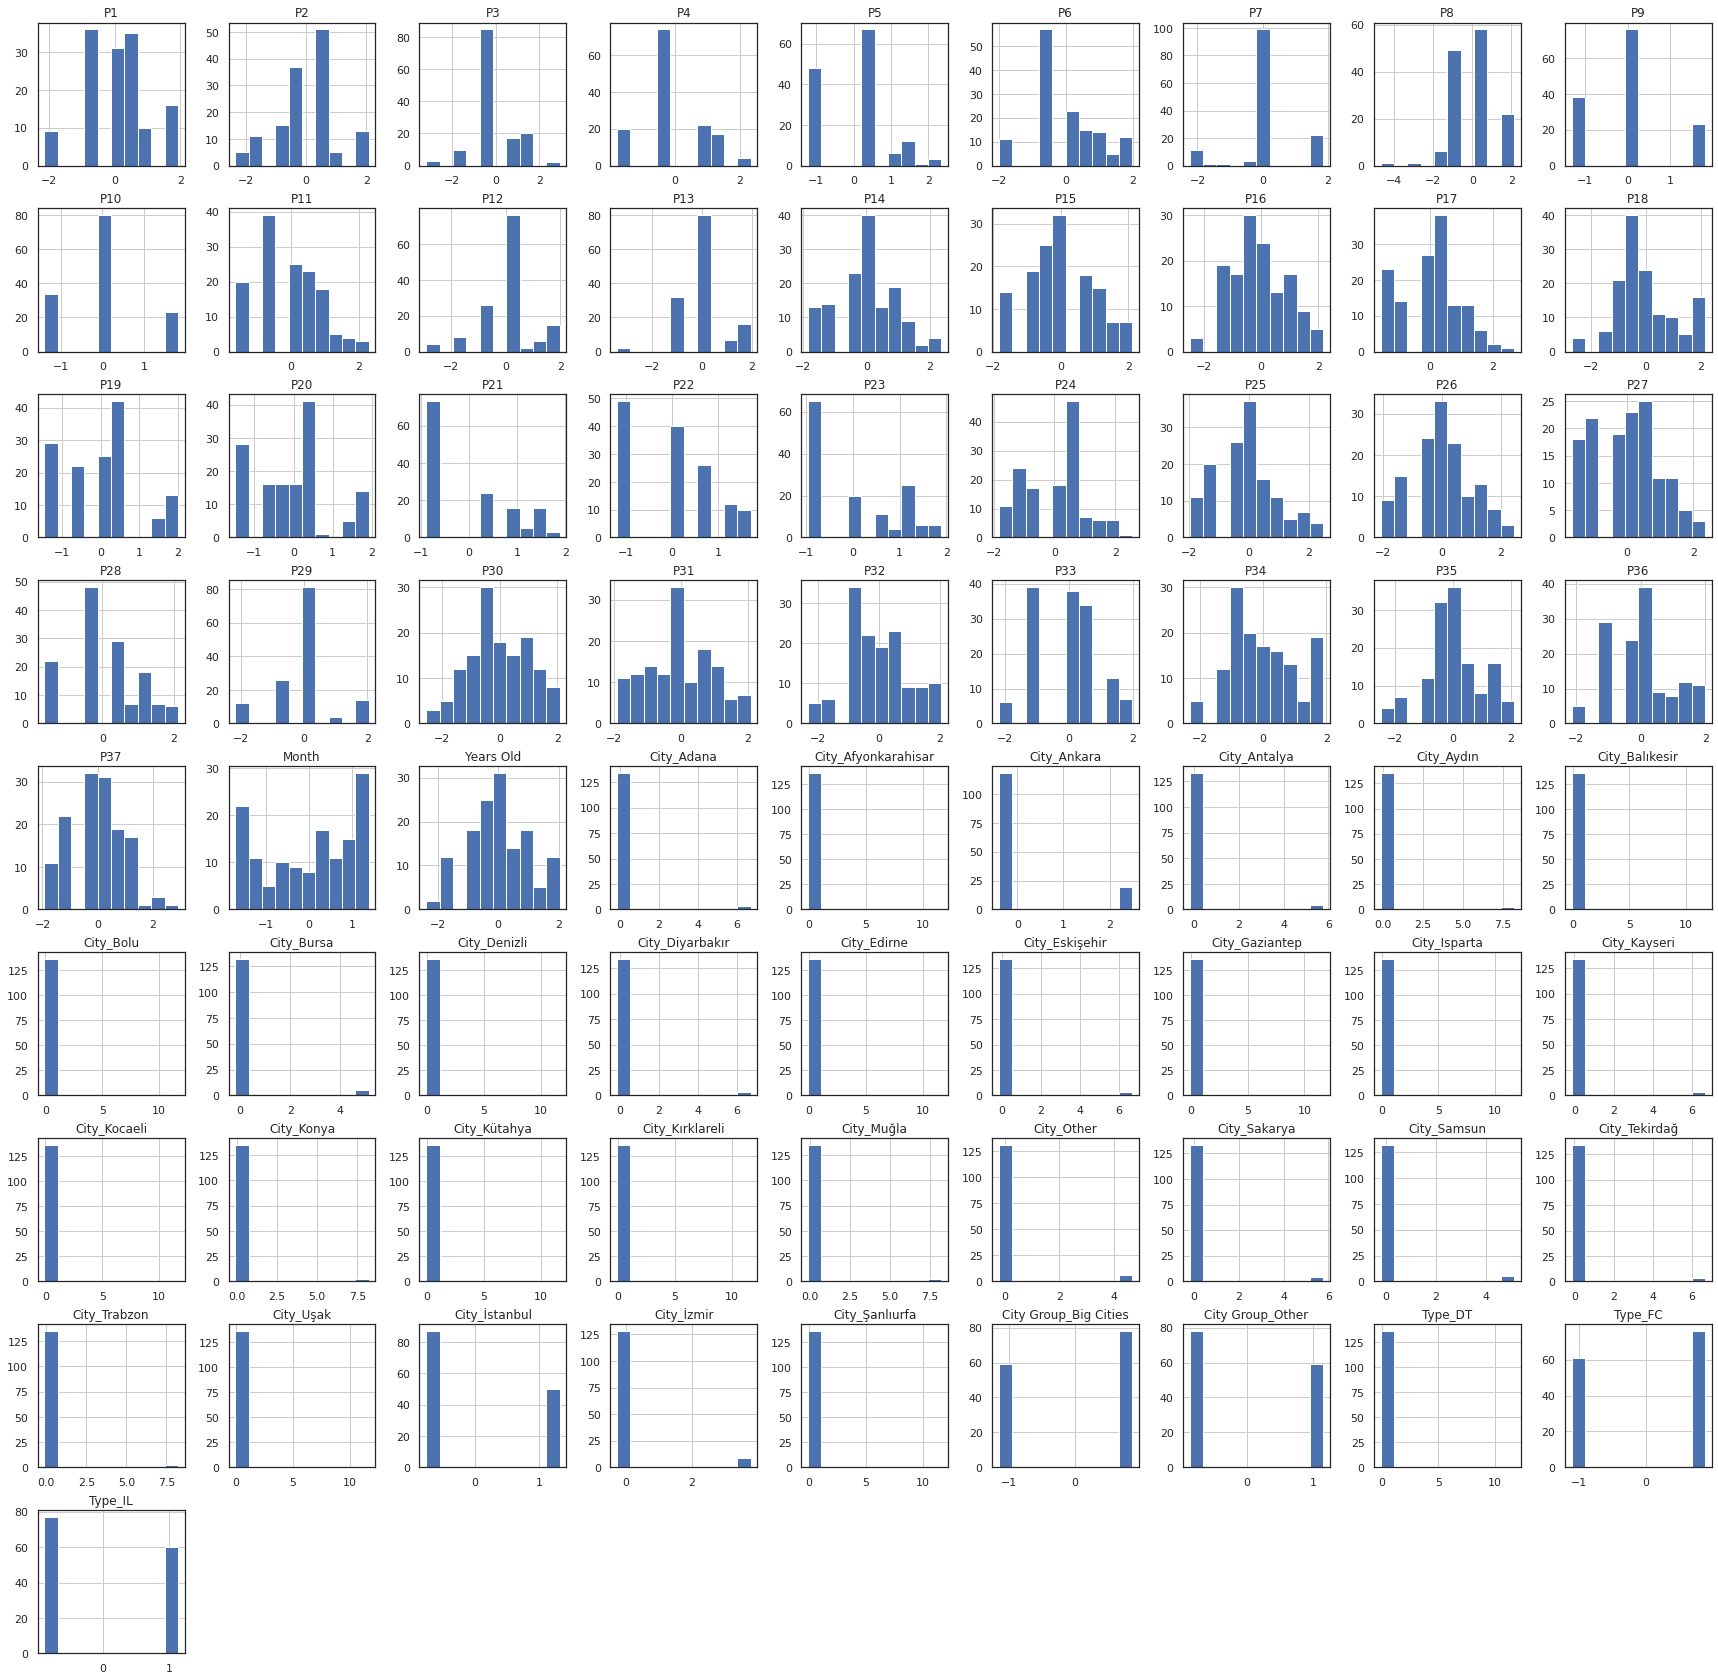

In [45]:
#Normalise the Dataset

#using a power transformer to transform the dataset

from sklearn.preprocessing import PowerTransformer
# Reset the data
# Init
pt = preprocessing.PowerTransformer()

scalednewdf = pt.fit_transform(X)
X = pd.DataFrame(scalednewdf, columns=X.columns)
X.hist(figsize=(30, 30));

In [46]:
X.head()

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37,Month,Years Old,City_Adana,City_Afyonkarahisar,City_Ankara,City_Antalya,City_Aydın,City_Balıkesir,City_Bolu,City_Bursa,City_Denizli,City_Diyarbakır,City_Edirne,City_Eskişehir,City_Gaziantep,City_Isparta,City_Kayseri,City_Kocaeli,City_Konya,City_Kütahya,City_Kırklareli,City_Muğla,City_Other,City_Sakarya,City_Samsun,City_Tekirdağ,City_Trabzon,City_Uşak,City_İstanbul,City_İzmir,City_Şanlıurfa,City Group_Big Cities,City Group_Other,Type_DT,Type_FC,Type_IL
0,0.402120,0.379267,-0.289734,-0.212812,0.362117,-0.615819,-0.119084,-0.600861,0.139676,0.095506,0.100622,0.031706,0.093727,-1.844462,-1.006670,-1.428458,-0.850813,-0.320584,0.612194,0.195040,-0.887749,0.829292,0.634463,-1.832848,-1.961400,-2.071535,0.142888,-0.419547,0.143422,-0.439681,-0.776691,-0.598687,1.376048,0.030682,-0.525777,-1.137787,0.255847,-0.012592,1.818767,-0.149626,-0.085749,-0.401269,-0.173422,-0.121716,-0.085749,-0.085749,-0.194625,-0.085749,-0.149626,-0.085749,-0.149626,-0.085749,-0.085749,-0.149626,-0.085749,-0.121716,-0.085749,-0.085749,-0.121716,-0.214013,-0.173422,-0.194625,-0.149626,-0.121716,-0.085749,1.319091,-0.265165,-0.085749,0.869718,-0.869718,-0.085749,-1.116200,1.132843
1,0.402120,0.379267,-0.289734,-0.212812,-1.222078,-0.615819,-0.119084,0.091085,0.139676,0.095506,-1.658569,0.031706,0.093727,0.558824,1.860519,0.508313,-0.850813,-0.864914,-0.013704,-0.705839,-0.887749,0.829292,0.111048,-0.034598,1.675087,0.341358,-0.326259,0.273748,0.143422,-0.439681,0.785530,0.581572,-1.007960,0.030682,-0.525777,0.332805,-0.352763,-1.416074,0.502705,-0.149626,-0.085749,2.492093,-0.173422,-0.121716,-0.085749,-0.085749,-0.194625,-0.085749,-0.149626,-0.085749,-0.149626,-0.085749,-0.085749,-0.149626,-0.085749,-0.121716,-0.085749,-0.085749,-0.121716,-0.214013,-0.173422,-0.194625,-0.149626,-0.121716,-0.085749,-0.758098,-0.265165,-0.085749,0.869718,-0.869718,-0.085749,0.895897,-0.882735
2,-0.847857,-0.235671,-3.184189,0.777260,0.362117,0.162948,-0.119084,0.091085,0.139676,0.095506,-0.602556,0.031706,0.093727,0.241244,-0.383358,-1.428458,-0.302226,-0.864914,-1.461894,-1.491619,-0.887749,-1.182493,-0.959603,-0.526711,0.140450,0.341358,1.189341,-1.629716,0.143422,0.247553,0.540490,0.736397,-1.007960,-1.328176,-0.525777,-0.482934,1.282357,-1.133629,-1.602104,-0.149626,-0.085749,-0.401269,-0.173422,-0.121716,-0.085749,-0.085749,-0.194625,-0.085749,6.683313,-0.085749,-0.149626,-0.085749,-0.085749,-0.149626,-0.085749,-0.121716,-0.085749,-0.085749,-0.121716,-0.214013,-0.173422,-0.194625,-0.149626,-0.121716,-0.085749,-0.758098,-0.265165,-0.085749,-1.149797,1.149797,-0.085749,-1.116200,1.132843
3,1.040770,-0.235671,1.572045,1.457053,1.579756,0.674633,1.855832,1.502042,1.819274,1.820408,1.894834,1.980641,1.950886,0.558824,0.125595,1.219044,-0.302226,1.747388,1.865482,1.645395,1.596209,-1.182493,1.598090,-1.107280,-1.072254,-1.194721,-0.906181,-0.419547,2.051638,1.844565,1.593870,0.736397,1.980831,1.619464,1.627483,1.419363,1.282357,-1.416074,-0.993350,-0.149626,-0.085749,-0.401269,-0.173422,-0.121716,-0.085749,-0.085749,-0.194625,-0.085749,-0.149626,-0.085749,-0.149626,-0.085749,-0.085749,-0.149626,-0.085749,-0.121716,-0.085749,-0.085749,-0.121716,4.672615,-0.173422,-0.194625,-0.149626,-0.121716,-0.085749,-0.758098,-0.265165,-0.085749,-1.149797,1.149797,-0.085749,-1.116200,1.132843
4,-0.097603,-0.235671,-1.543935,-0.212812,0.362117,-0.615819,-0.119084,0.091085,0.139676,0.095506,-0.602556,0.031706,0.093727,-1.109631,-1.826100,-1.428458,-1.585982,-0.320584,-0.549372,-0.705839,-0.887749,0.083867,-0.959603,-1.107280,-0.402495,-0.562941,0.539227,-1.629716,0.143422,-0.439681,-1.903032,-0.999787,-1.007960,-0.719629,-0.525777,-1.137787,-0.352763,-0.571696,0.224462,-0.149626,-0.085749,-0.401269,-0.173422,-0.121716,-0.085749,-0.085749,-0.194625,-0.085749,-0.149626,-0.085749,-0.149626,11.661904,-0.085749,-0.149626,-0.085749,-0.121716,-0.085749,-0.085749,-

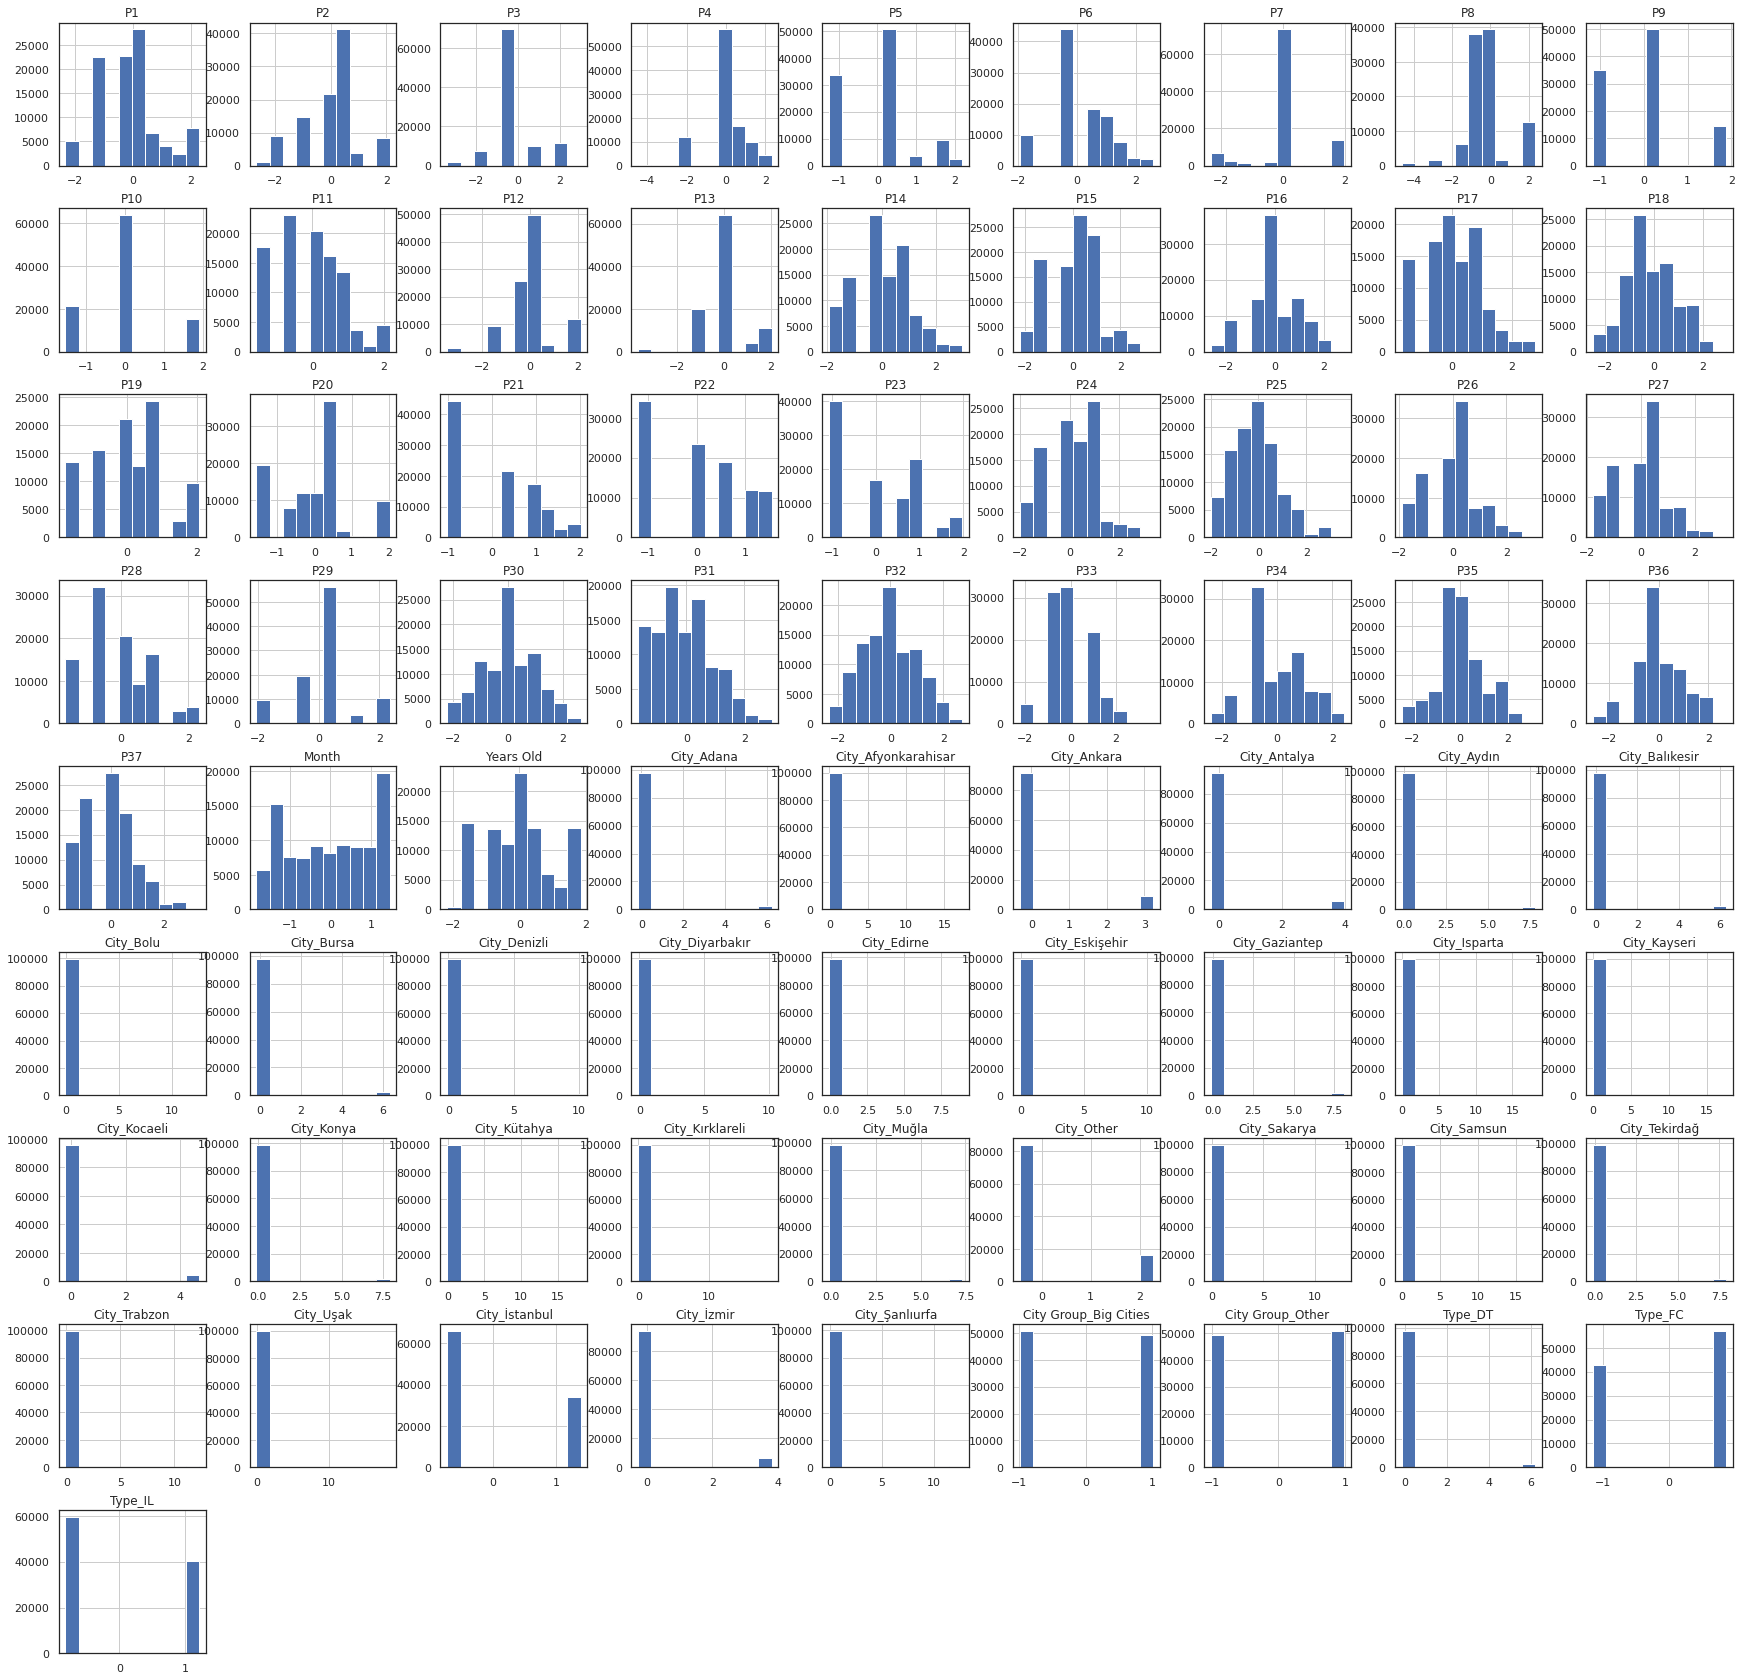

In [47]:

from sklearn.preprocessing import PowerTransformer
# Reset the data
# Init
pt = preprocessing.PowerTransformer()

scalednewdf = pt.fit_transform(df_test)
df_test = pd.DataFrame(scalednewdf, columns=df_test.columns)
df_test.hist(figsize=(30, 30));

In [48]:
df_test.head(3)

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37,Month,Years Old,City_Adana,City_Afyonkarahisar,City_Ankara,City_Antalya,City_Aydın,City_Balıkesir,City_Bolu,City_Bursa,City_Denizli,City_Diyarbakır,City_Edirne,City_Eskişehir,City_Gaziantep,City_Isparta,City_Kayseri,City_Kocaeli,City_Konya,City_Kütahya,City_Kırklareli,City_Muğla,City_Other,City_Sakarya,City_Samsun,City_Tekirdağ,City_Trabzon,City_Uşak,City_İstanbul,City_İzmir,City_Şanlıurfa,City Group_Big Cities,City Group_Other,Type_DT,Type_FC,Type_IL
0,-2.313791,-0.244308,-0.210087,-0.247834,-1.251337,-0.508611,-0.069796,-0.492410,0.303880,0.080671,0.979858,-1.698480,-1.311026,-1.939166,0.146109,1.381992,-0.755684,0.403763,0.533627,0.461503,0.844048,-1.202826,0.825220,-1.065934,-0.402551,-1.015656,0.225468,-0.498458,0.146583,-0.506495,-1.672968,-0.104798,0.082851,-0.175606,-0.983431,-0.097780,0.648613,-1.821127,-0.486082,-0.160587,-0.057628,-0.309080,-0.250646,-0.128202,-0.158909,-0.079687,-0.15818,-0.09866,-0.098142,-0.111594,-0.095298,-0.122859,-0.05522,-0.056925,-0.213615,-0.126540,-0.05522,-0.053084,-0.136266,2.270792,-0.077953,-0.057013,-0.126581,-0.08151,-0.054209,-0.719132,-0.262904,-0.078277,-0.985544,0.985544,-0.161241,0.868217,-0.824122
1,-0.194380,-0.244308,-0.210087,-0.247834,0.332676,-0.508611,-0.069796,-1.407802,-1.178419,-1.533799,-0.564293,-0.581243,0.073714,-0.972952,1.086839,0.412181,0.663564,0.712092,0.533627,0.461503,0.844048,-0.088696,-1.080539,0.216648,0.679592,-0.370796,0.225468,-1.659616,0.146583,-0.915873,-0.293172,0.993825,1.588683,0.827226,-0.983431,0.901797,0.036386,-1.171590,-0.486082,-0.160587,-0.057628,-0.309080,-0.250646,-0.128202,-0.158909,-0.079687,-0.15818,-0.09866,-0.098142,-0.111594,-0.095298,-0.122859,-0.05522,-0.056925,-0.213615,7.902644,-0.05522,-0.053084,-0.136266,-0.440375,-0.077953,-0.057013,-0.126581,-0.08151,-0.054209,-0.719132,-0.262904,-0.078277,-0.985544,0.985544,-0.161241,-1.151785,1.213413
2,-0.194380,-0.244308,-0.210087,-0.247834,0.332676,-0.508611,-0.069796,-0.492410,-1.178419,0.080671,0.593838,0.199446,0.073714,1.387359,0.146109,-0.351272,0.957081,0.712092,0.533627,0.461503,1.401249,1.541837,1.050864,0.216648,-1.102918,-0.370796,-0.281020,-0.498458,0.146583,0.541963,1.459890,0.993825,0.082851,-0.505897,0.848014,0.704646,1.168393,0.900434,-1.470837,-0.160587,-0.057628,3.235412,-0.250646,-0.128202,-0.158909,-0.079687,-0.15818,-0.09866,-0.098142,-0.111594,-0.095298,-0.122859,-0.05522,-0.056925,-0.213615,-0.126540,-0.05522,-0.053084,-0.136266,-0.440375,-0.077953,-0.057013,-0.126581,-0.08151,-0.054209,-0.719132,-0.262904,-0.078277,1.014668,-1.014668,-0.161241,0.868217,-0.824122


In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=118)

In [50]:
X_test.shape , X_train.shape

((35, 73), (102, 73))

In [51]:
df_test.head(3)

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37,Month,Years Old,City_Adana,City_Afyonkarahisar,City_Ankara,City_Antalya,City_Aydın,City_Balıkesir,City_Bolu,City_Bursa,City_Denizli,City_Diyarbakır,City_Edirne,City_Eskişehir,City_Gaziantep,City_Isparta,City_Kayseri,City_Kocaeli,City_Konya,City_Kütahya,City_Kırklareli,City_Muğla,City_Other,City_Sakarya,City_Samsun,City_Tekirdağ,City_Trabzon,City_Uşak,City_İstanbul,City_İzmir,City_Şanlıurfa,City Group_Big Cities,City Group_Other,Type_DT,Type_FC,Type_IL
0,-2.313791,-0.244308,-0.210087,-0.247834,-1.251337,-0.508611,-0.069796,-0.492410,0.303880,0.080671,0.979858,-1.698480,-1.311026,-1.939166,0.146109,1.381992,-0.755684,0.403763,0.533627,0.461503,0.844048,-1.202826,0.825220,-1.065934,-0.402551,-1.015656,0.225468,-0.498458,0.146583,-0.506495,-1.672968,-0.104798,0.082851,-0.175606,-0.983431,-0.097780,0.648613,-1.821127,-0.486082,-0.160587,-0.057628,-0.309080,-0.250646,-0.128202,-0.158909,-0.079687,-0.15818,-0.09866,-0.098142,-0.111594,-0.095298,-0.122859,-0.05522,-0.056925,-0.213615,-0.126540,-0.05522,-0.053084,-0.136266,2.270792,-0.077953,-0.057013,-0.126581,-0.08151,-0.054209,-0.719132,-0.262904,-0.078277,-0.985544,0.985544,-0.161241,0.868217,-0.824122
1,-0.194380,-0.244308,-0.210087,-0.247834,0.332676,-0.508611,-0.069796,-1.407802,-1.178419,-1.533799,-0.564293,-0.581243,0.073714,-0.972952,1.086839,0.412181,0.663564,0.712092,0.533627,0.461503,0.844048,-0.088696,-1.080539,0.216648,0.679592,-0.370796,0.225468,-1.659616,0.146583,-0.915873,-0.293172,0.993825,1.588683,0.827226,-0.983431,0.901797,0.036386,-1.171590,-0.486082,-0.160587,-0.057628,-0.309080,-0.250646,-0.128202,-0.158909,-0.079687,-0.15818,-0.09866,-0.098142,-0.111594,-0.095298,-0.122859,-0.05522,-0.056925,-0.213615,7.902644,-0.05522,-0.053084,-0.136266,-0.440375,-0.077953,-0.057013,-0.126581,-0.08151,-0.054209,-0.719132,-0.262904,-0.078277,-0.985544,0.985544,-0.161241,-1.151785,1.213413
2,-0.194380,-0.244308,-0.210087,-0.247834,0.332676,-0.508611,-0.069796,-0.492410,-1.178419,0.080671,0.593838,0.199446,0.073714,1.387359,0.146109,-0.351272,0.957081,0.712092,0.533627,0.461503,1.401249,1.541837,1.050864,0.216648,-1.102918,-0.370796,-0.281020,-0.498458,0.146583,0.541963,1.459890,0.993825,0.082851,-0.505897,0.848014,0.704646,1.168393,0.900434,-1.470837,-0.160587,-0.057628,3.235412,-0.250646,-0.128202,-0.158909,-0.079687,-0.15818,-0.09866,-0.098142,-0.111594,-0.095298,-0.122859,-0.05522,-0.056925,-0.213615,-0.126540,-0.05522,-0.053084,-0.136266,-0.440375,-0.077953,-0.057013,-0.126581,-0.08151,-0.054209,-0.719132,-0.262904,-0.078277,1.014668,-1.014668,-0.161241,0.868217,-0.824122


In [52]:
X.head(3)

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37,Month,Years Old,City_Adana,City_Afyonkarahisar,City_Ankara,City_Antalya,City_Aydın,City_Balıkesir,City_Bolu,City_Bursa,City_Denizli,City_Diyarbakır,City_Edirne,City_Eskişehir,City_Gaziantep,City_Isparta,City_Kayseri,City_Kocaeli,City_Konya,City_Kütahya,City_Kırklareli,City_Muğla,City_Other,City_Sakarya,City_Samsun,City_Tekirdağ,City_Trabzon,City_Uşak,City_İstanbul,City_İzmir,City_Şanlıurfa,City Group_Big Cities,City Group_Other,Type_DT,Type_FC,Type_IL
0,0.402120,0.379267,-0.289734,-0.212812,0.362117,-0.615819,-0.119084,-0.600861,0.139676,0.095506,0.100622,0.031706,0.093727,-1.844462,-1.006670,-1.428458,-0.850813,-0.320584,0.612194,0.195040,-0.887749,0.829292,0.634463,-1.832848,-1.961400,-2.071535,0.142888,-0.419547,0.143422,-0.439681,-0.776691,-0.598687,1.376048,0.030682,-0.525777,-1.137787,0.255847,-0.012592,1.818767,-0.149626,-0.085749,-0.401269,-0.173422,-0.121716,-0.085749,-0.085749,-0.194625,-0.085749,-0.149626,-0.085749,-0.149626,-0.085749,-0.085749,-0.149626,-0.085749,-0.121716,-0.085749,-0.085749,-0.121716,-0.214013,-0.173422,-0.194625,-0.149626,-0.121716,-0.085749,1.319091,-0.265165,-0.085749,0.869718,-0.869718,-0.085749,-1.116200,1.132843
1,0.402120,0.379267,-0.289734,-0.212812,-1.222078,-0.615819,-0.119084,0.091085,0.139676,0.095506,-1.658569,0.031706,0.093727,0.558824,1.860519,0.508313,-0.850813,-0.864914,-0.013704,-0.705839,-0.887749,0.829292,0.111048,-0.034598,1.675087,0.341358,-0.326259,0.273748,0.143422,-0.439681,0.785530,0.581572,-1.007960,0.030682,-0.525777,0.332805,-0.352763,-1.416074,0.502705,-0.149626,-0.085749,2.492093,-0.173422,-0.121716,-0.085749,-0.085749,-0.194625,-0.085749,-0.149626,-0.085749,-0.149626,-0.085749,-0.085749,-0.149626,-0.085749,-0.121716,-0.085749,-0.085749,-0.121716,-0.214013,-0.173422,-0.194625,-0.149626,-0.121716,-0.085749,-0.758098,-0.265165,-0.085749,0.869718,-0.869718,-0.085749,0.895897,-0.882735
2,-0.847857,-0.235671,-3.184189,0.777260,0.362117,0.162948,-0.119084,0.091085,0.139676,0.095506,-0.602556,0.031706,0.093727,0.241244,-0.383358,-1.428458,-0.302226,-0.864914,-1.461894,-1.491619,-0.887749,-1.182493,-0.959603,-0.526711,0.140450,0.341358,1.189341,-1.629716,0.143422,0.247553,0.540490,0.736397,-1.007960,-1.328176,-0.525777,-0.482934,1.282357,-1.133629,-1.602104,-0.149626,-0.085749,-0.401269,-0.173422,-0.121716,-0.085749,-0.085749,-0.194625,-0.085749,6.683313,-0.085749,-0.149626,-0.085749,-0.085749,-0.149626,-0.085749,-0.121716,-0.085749,-0.085749,-0.121716,-0.214013,-0.173422,-0.194625,-0.149626,-0.121716,-0.085749,-0.758098,-0.265165,-0.085749,-1.149797,1.149797,-0.085749,-1.116200,1.132843


In [53]:
y_test.head(3)

102    2738052.0
88     2025297.0
77     1904842.0
Name: revenue, dtype: float64

##Start the Machine Learning Process

#Feature Engineering

### Regression

##Hyper Parameter Tuning 

In [54]:
from sklearn.ensemble import RandomForestRegressor

params_rf = {
    'max_depth': [10, 30, 35, 50, 65, 75, 100],
    'max_features': [.3, .4, .5, .6],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [30, 50, 100, 200]
}

rf = RandomForestRegressor()
rf_regressor = GridSearchCV(rf, params_rf, scoring='neg_root_mean_squared_error', cv = 10, n_jobs = -1)
rf_regressor.fit(X_train, y_train)
print(f'Optimal depth: {rf_regressor.best_params_["max_depth"]}')
print(f'Optimal max_features: {rf_regressor.best_params_["max_features"]}')
print(f'Optimal min_sample_leaf: {rf_regressor.best_params_["min_samples_leaf"]}')
print(f'Optimal min_samples_split: {rf_regressor.best_params_["min_samples_split"]}')
print(f'Optimal n_estimators: {rf_regressor.best_params_["n_estimators"]}')
print(f'Best score: {rf_regressor.best_score_}')

Optimal depth: 75
Optimal max_features: 0.5
Optimal min_sample_leaf: 4
Optimal min_samples_split: 10
Optimal n_estimators: 30
Best score: -1834816.4677188895


In [55]:
rf_model = RandomForestRegressor(max_depth=rf_regressor.best_params_["max_depth"], 
                                 max_features=rf_regressor.best_params_["max_features"], 
                                 min_samples_leaf=rf_regressor.best_params_["min_samples_leaf"], 
                                 min_samples_split=rf_regressor.best_params_["min_samples_split"], 
                                 n_estimators=rf_regressor.best_params_["n_estimators"], 
                                 n_jobs=-1, oob_score=True)
rf_model.fit(X_train, y_train)
y_train_pred = rf_model.predict(X_train)
y_pred = rf_model.predict(X_test)
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))
train_rmse = np.sqrt(mean_squared_error(y_train_pred, y_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

Train r2 score:  -1.267203646817789
Test r2 score:  0.1471938810379818
Train RMSE: 1350659.9991
Test RMSE: 3359136.6252


Train r2 score:  -2.3204211015061387
Test r2 score:  0.1388673113644625
Train RMSE: 1725425.5797
Test RMSE: 3097150.4230

In [56]:
# submission = pd.DataFrame(columns=['Id','Prediction'])
submission7 = pd.DataFrame(columns=['Prediction'])
# submission['Id'] = df_test['Id']

In [57]:

rf_pred = rf_model.predict(df_test)
submission7['Id'] = ID
submission7['Prediction'] = rf_pred

submission7 = submission7.iloc[:, [1,0]]

## This is a sample of one of the predictions our model is making for the test set that was given to us. 

In [85]:
submission7.head(10)

,Id,Prediction
0,0,3.914622e+06
1,1,4.393642e+06
2,2,3.640919e+06
3,3,3.161259e+06
4,4,4.068895e+06
5,5,3.599860e+06
6,6,4.313858e+06
7,7,3.868655e+06
8,8,4.748821e+06
9,9,4.339427e+06


In [58]:
submission7.to_csv('/content/drive/MyDrive/CIS508/Team_Assignment/Kaggle_Submissions/submission_rf3_Scaled.csv',index=False)

43 features with reduction of 41.10%


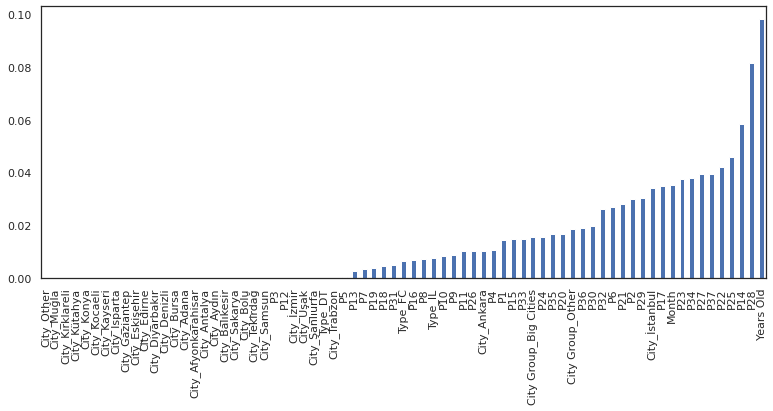

In [59]:
# Random Forest Model Feature Importance
rf_feature_importance = pd.Series(index = X_train.columns, data = np.abs(rf_model.feature_importances_))

n_features = (rf_feature_importance>0).sum()

print(f'{n_features} features with reduction of {(1-n_features/len(rf_feature_importance))*100:2.2f}%')

rf_feature_importance.sort_values().plot(kind = 'bar', figsize = (13,5));

### Experimenting with XGBoost Regressor

In [60]:
params_xgb = {
    'learning_rate': [.1, .5, .7, .9, .95, .99, 1],
    'colsample_bytree': [.3, .4, .5, .6],
    'max_depth': [4],
    'alpha': [3],
    'subsample': [.5],
    'n_estimators': [30, 70, 100, 200]
}

xgb_model = XGBRegressor()
xgb_regressor = GridSearchCV(xgb_model, params_xgb, scoring='neg_root_mean_squared_error', cv = 10, n_jobs = -1)
xgb_regressor.fit(X_train, y_train)
print(f'Optimal lr: {xgb_regressor.best_params_["learning_rate"]}')
print(f'Optimal colsample_bytree: {xgb_regressor.best_params_["colsample_bytree"]}')
print(f'Optimal n_estimators: {xgb_regressor.best_params_["n_estimators"]}')
print(f'Best score: {xgb_regressor.best_score_}')

[05:29:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Optimal lr: 0.1
Optimal colsample_bytree: 0.4
Optimal n_estimators: 100
Best score: -1874931.7142149806


In [61]:
# XGB with early stopping
xgb_model.fit(X_train, y_train, early_stopping_rounds=4,
             eval_set=[(X_test, y_test)], verbose=False)
y_train_pred = xgb_model.predict(X_train)
y_pred = xgb_model.predict(X_test)
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))
train_rmse = np.sqrt(mean_squared_error(y_train_pred, y_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

[05:29:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train r2 score:  0.8659314139276629
Test r2 score:  0.2010204558850115
Train RMSE: 591903.5847
Test RMSE: 3251399.5737


In [62]:
xgb_model = XGBRegressor(learning_rate=xgb_regressor.best_params_["learning_rate"], 
                         colsample_bytree=xgb_regressor.best_params_["colsample_bytree"], 
                         max_depth=4, alpha=3, subsample=.5, 
                         n_estimators=xgb_regressor.best_params_["n_estimators"], n_jobs=-1)
xgb_model.fit(X_train, y_train)
y_train_pred = xgb_model.predict(X_train)
y_pred = xgb_model.predict(X_test)
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))
train_rmse = np.sqrt(mean_squared_error(y_train_pred, y_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

[05:29:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train r2 score:  0.9859479215216121
Test r2 score:  0.20957640765238594
Train RMSE: 225075.5168
Test RMSE: 3233943.7485


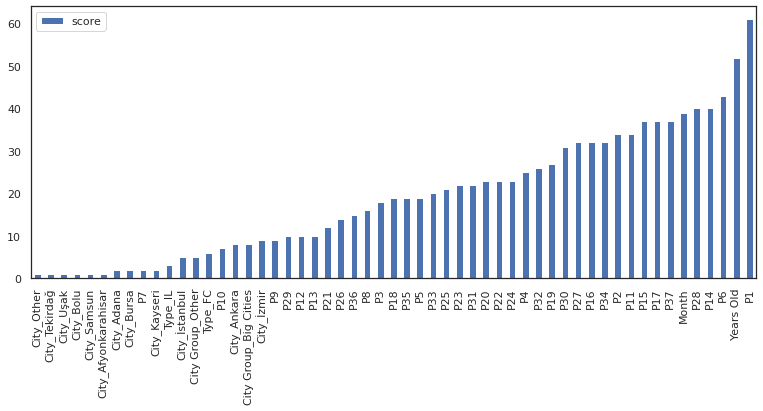

In [63]:
# XGB Feature Importance, relevant features can be selected based on its score
feature_important = xgb_model.get_booster().get_fscore()
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=['score']).sort_values(by = 'score', ascending=True)
data.plot(kind='bar', figsize = (13,5))
plt.show()

In [64]:
submission9 = pd.DataFrame(columns=['Id','Prediction'])
submission9['Id'] = ID['Id']

In [65]:
xgb_pred = xgb_model.predict(df_test)
submission9['Prediction'] = xgb_pred
submission9.to_csv('/content/drive/MyDrive/CIS508/Team_Assignment/Kaggle_Submissions/submission_xgb1.csv',index=False)

##Now using ElasticNet

In [66]:
from sklearn.linear_model import ElasticNetCV, ElasticNet

# Use ElasticNetCV to tune alpha automatically instead of redundantly using ElasticNet and GridSearchCV
el_model = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], eps=5e-2, cv=10, n_jobs=-1)         
el_model.fit(X_train, y_train)
print(f'Optimal alpha: {el_model.alpha_:.6f}')
print(f'Optimal l1_ratio: {el_model.l1_ratio_:.3f}')
print(f'Number of iterations {el_model.n_iter_}')

Optimal alpha: 180746.859998
Optimal l1_ratio: 1.000
Number of iterations 336


In [67]:
y_train_pred = el_model.predict(X_train)
y_pred = el_model.predict(X_test)
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))
train_rmse = np.sqrt(mean_squared_error(y_train_pred, y_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

Train r2 score:  -5.947607651488109
Test r2 score:  0.17097320217806067
Train RMSE: 1779967.3434
Test RMSE: 3311973.0849


10 features with reduction of 86.30%


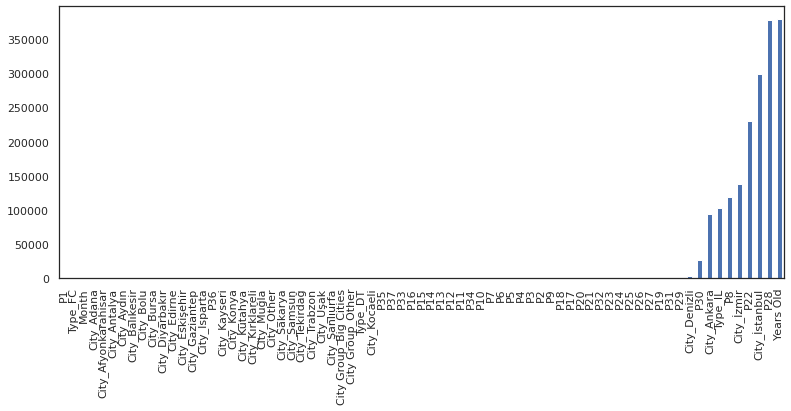

In [68]:
# ElasticNet Model Feature Importance
el_feature_coef = pd.Series(index = X_train.columns, data = np.abs(el_model.coef_))
n_features = (el_feature_coef>0).sum()
print(f'{n_features} features with reduction of {(1-n_features/len(el_feature_coef))*100:2.2f}%')
el_feature_coef.sort_values().plot(kind = 'bar', figsize = (13,5));

In [69]:
submission10 = pd.DataFrame(columns=['Id','Prediction'])
submission10['Id'] = ID['Id']

In [70]:
el_model = el_model.predict(df_test)
submission10['Prediction'] = el_model
submission10.to_csv('/content/drive/MyDrive/CIS508/Team_Assignment/Kaggle_Submissions/submission_elm.csv',index=False)

### Now using RidgeRegressor

In [71]:

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [72]:
params_ridge = {
    'alpha' : [.01, .1, .5, .7, .9, .95, .99, 1, 5, 10, 20],
    'fit_intercept' : [True, False],
    'normalize' : [True,False],
    'solver' : ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

ridge_model = Ridge()
ridge_regressor = GridSearchCV(ridge_model, params_ridge, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)
ridge_regressor.fit(X_train, y_train)
print(f'Optimal alpha: {ridge_regressor.best_params_["alpha"]:.2f}')
print(f'Optimal fit_intercept: {ridge_regressor.best_params_["fit_intercept"]}')
print(f'Optimal normalize: {ridge_regressor.best_params_["normalize"]}')
print(f'Optimal solver: {ridge_regressor.best_params_["solver"]}')
print(f'Best score: {ridge_regressor.best_score_}')

Optimal alpha: 5.00
Optimal fit_intercept: True
Optimal normalize: True
Optimal solver: sparse_cg
Best score: -1942394.882450568


In [73]:
ridge_model = Ridge(alpha=ridge_regressor.best_params_["alpha"], fit_intercept=ridge_regressor.best_params_["fit_intercept"], 
                    normalize=ridge_regressor.best_params_["normalize"], solver=ridge_regressor.best_params_["solver"])
ridge_model.fit(X_train, y_train)
y_train_pred = ridge_model.predict(X_train)
y_pred = ridge_model.predict(X_test)
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))
train_rmse = np.sqrt(mean_squared_error(y_train_pred, y_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

Train r2 score:  -25.013479363123288
Test r2 score:  0.07983968028018007
Train RMSE: 1881112.8671
Test RMSE: 3489267.4959


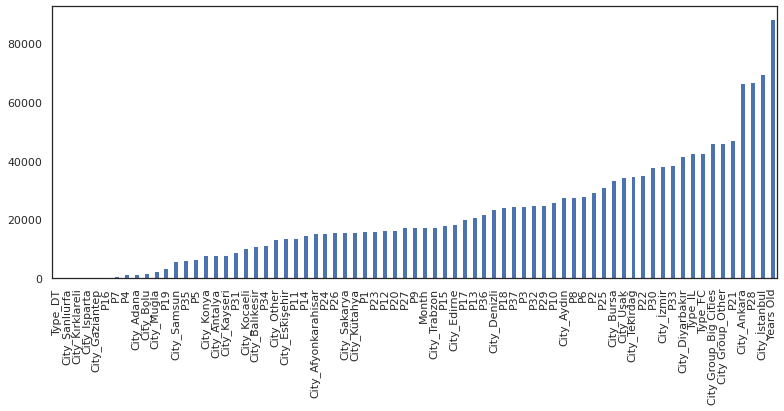

In [74]:
# Ridge Model Feature Importance
ridge_feature_coef = pd.Series(index = X_train.columns, data = np.abs(ridge_model.coef_))
ridge_feature_coef.sort_values().plot(kind = 'bar', figsize = (13,5));

In [75]:
submission14 = pd.DataFrame(columns=['Id','Prediction'])
submission14['Id'] = ID['Id']

ridge_pred = ridge_model.predict(df_test)
submission14['Prediction'] = ridge_pred
submission14.to_csv('/content/drive/MyDrive/CIS508/Team_Assignment/Kaggle_Submissions/submission_ridge_reg.csv',index=False)

### Experimenting with Stacking the Models

#### We build a stacked classifier using XGBoost as the Meta Model

In [76]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
# define the base models
base_models = list()
# base_models.append(('XGBoost', xgb_model))
base_models.append(('rf', rf_model))
base_models.append(('rf3', RandomForestRegressor(max_depth=8, max_features=0.1, min_samples_leaf=3, 
                                                min_samples_split=2, n_estimators=250, n_jobs=-1, oob_score=False)))
base_models.append(('rf4', RandomForestRegressor(max_depth=6, max_features=0.4, min_samples_leaf=4, 
                                                min_samples_split=2, n_estimators=300, oob_score=False)))
# define meta learner model
learner = XGBRegressor(random_state = 5)
# define the stacking ensemble
stack1 = StackingRegressor(estimators=base_models, final_estimator=learner, cv=10)
# fit the model on all available data
stack1.fit(X, y)

[05:29:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


StackingRegressor(cv=10,
                  estimators=[('rf',
                               RandomForestRegressor(max_depth=75,
                                                     max_features=0.5,
                                                     min_samples_leaf=4,
                                                     min_samples_split=10,
                                                     n_estimators=30, n_jobs=-1,
                                                     oob_score=True)),
                              ('rf3',
                               RandomForestRegressor(max_depth=8,
                                                     max_features=0.1,
                                                     min_samples_leaf=3,
                                                     n_estimators=250,
                                                     n_jobs=-1)),
                              ('rf4',
                               RandomForestRegressor(max_depth=6,
           

### Hyperparameter Tuning of the Stacked Model

In [77]:
grid_params_xgb =     {
     'final_estimator__learning_rate': [0.05,0.1],
     'final_estimator__max_depth': [7, 10, 15],
     'final_estimator__min_child_weight': [1,5,7,12],
     'final_estimator__gamma': [0.1, 0.2, 0.3],
     'final_estimator__n_estimators': [50, 70, 90, 110],
     'final_estimator__scale_pos_weight': [0.2, 0.5, 1],
     "final_estimator__use_label_encoder": [False],
     'final_estimator__subsample': [0.5, 0.7, 1]     }

In [78]:
grid_stacker = RandomizedSearchCV(estimator = stack1, param_distributions = grid_params_xgb,
                                  scoring = "neg_mean_absolute_error", n_jobs = 6, cv = 5, verbose = 3, n_iter=50)

In [79]:
grid_stacker.fit(X, y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[06:04:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=5,
                   estimator=StackingRegressor(cv=10,
                                               estimators=[('rf',
                                                            RandomForestRegressor(max_depth=75,
                                                                                  max_features=0.5,
                                                                                  min_samples_leaf=4,
                                                                                  min_samples_split=10,
                                                                                  n_estimators=30,
                                                                                  n_jobs=-1,
                                                                                  oob_score=True)),
                                                           ('rf3',
                                                            RandomForestRegressor(max_depth=8,

In [80]:
print(grid_stacker.best_params_, grid_stacker.best_score_)

{'final_estimator__use_label_encoder': False, 'final_estimator__subsample': 0.7, 'final_estimator__scale_pos_weight': 0.2, 'final_estimator__n_estimators': 50, 'final_estimator__min_child_weight': 5, 'final_estimator__max_depth': 10, 'final_estimator__learning_rate': 0.1, 'final_estimator__gamma': 0.2} -1740465.1955687832


In [81]:
# grid_stacker.best_params_

In [82]:
best_params_stacker = {'use_label_encoder': False, 'subsample': 1, 'scale_pos_weight': 0.2,
                       'n_estimators': 50, 'min_child_weight': 12,
                       'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0.3}

In [83]:
stacked_classifier = XGBRegressor(random_state = 5, **best_params_stacker,verbosity=0)

stacked_classifier.fit(X, y)



XGBRegressor(gamma=0.3, learning_rate=0.05, max_depth=10, min_child_weight=12,
             n_estimators=50, random_state=5, scale_pos_weight=0.2,
             use_label_encoder=False, verbosity=0)

In [84]:
submission16 = pd.DataFrame(columns=['Id','Prediction'])
stack_pred = stacked_classifier.predict(df_test)

submission16['Id'] = ID['Id']

submission16['Prediction'] = stack_pred
submission16.to_csv('/content/drive/MyDrive/CIS508/Team_Assignment/Kaggle_Submissions/submission_stacked_HP_XGB.csv',index=False)

#Comparision and Analysis of Results

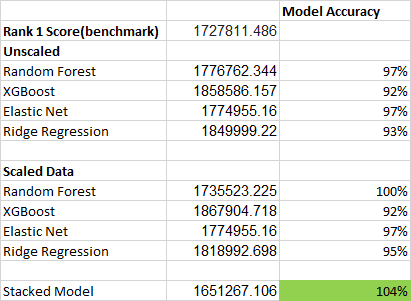


#### The benchmark score I'm taking for my model is the Highest Kaggle score, compared to that the Random Forest model using the scaled dataset achieves 100% accuracy. 
### However, when building a stacked model of different random forest models with hyperparameters tuned differently and then stacked using XGBoost as the Meta Model gives us 4% better accuracy than the best submission on Kaggle